In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.ndimage import gaussian_filter

import _pickle as cPickle
import scipy

from scipy.optimize import curve_fit
from scipy.signal import detrend


from glob import glob
import random
import json

import os

#import cmdstanpy
#import arviz 

%load_ext autoreload
%autoreload 2


## Issues

- Some data points still remaining in the graphs, and reset axis!
- Tune PID
- Frameinfor missing

In [2]:
import numpy as np
import pandas as pd
from PyQt6.QtCore import pyqtSignal,QThread, pyqtSlot
from tools.tools import EMA
import scipy

class positionScaling(QThread):
    magData = pyqtSignal(float)

    def __init__(self):

        super().__init__()
        self.position = None
        self.root = "./data/One_coil.csv"
        self.m = 3.5/(10*3.3*0.3)*1e-6
        #self.emaFilter = EMA(0.85)
        
        self.tracker = None
        self.past = 0

        self.B, self.rows, self.columns = self.load_csv(self.root)
        self.i = 0
 

    def load_csv(self, root):
        
        df = pd.read_csv(root, sep = ",", skiprows= [0,1], names = ["x", "y", "By", "Bx"])
        #drop not needed
        df.drop(df[df["y"].values < (0.0035 - 1536*m)].index, inplace = True)
        df.drop(df[df["x"].values > 0.00054].index, inplace = True)

        B = np.sqrt(df["By"]**2 + df["Bx"]**2)
        
        rows = df["x"].unique()
        columns = df["y"].unique()
        
        n_rows = len(rows)
        n_columns = len(columns)


        B = B.reshape(n_rows, n_columns)
        B = np.hstack((B[:,::-1], B))

        return B, rows, columns

    def initMag(self,x,y):
        x = x*self.m
        y = y*self.m

        x_idx = np.argmin(np.abs((self.rows-np.round(x,5))))
        y_idx = np.argmin(np.abs((self.columns-np.round(y,5))))
        self.past = self.B[x_idx, y_idx]


    def addCamera(self,camera):
        self.tracker = camera
        self.tracker.coordsScaler.connect(self.receiver)

    @pyqtSlot(object)
    def receiver(self, data):
        """
        Receive coordinates from Camera
        """
        if self.i == 10:
            x2 = data[1]
            x1 = data[0]
            y2 = data[3]#y2 = (1536 - data[3])
            y1 = data[2]#y1 = (1536 - data[2])

            self.findPoint((x1+x2)/2*self.m,(y1+y2)/2*self.m)
            self.i = 0
        else:
            self.i += 1
        

    def findPoint(self,x,y):

        x = x*self.m
        y = y*self.m

        x_idx = np.argmin(np.abs((self.rows-np.round(x,5))))
        y_idx = np.argmin(np.abs((self.columns-np.round(y,5))))
        current = self.B[x_idx, y_idx]
        error = self.prev - current
        self.prev = current

        self.emitData(error)
    
    def emitData(self, data):
        #print("Emiting: ", data)
        self.magData.emit(data)



In [3]:

def load_csv(root):
    
    df = pd.read_csv(root, sep = ",", skiprows= [0,1], names = ["x", "y", "By", "Bx"])
    #drop not needed
    df.drop(df[df["y"].values < (0.0035 - 1536*m)].index, inplace = True)
    df.drop(df[df["x"].values > 0.00054].index, inplace = True)

    B = np.sqrt(df["By"]**2 + df["Bx"]**2)
    
    rows = df["x"].unique()
    columns = df["y"].unique()

    return B, rows, columns


def findPoint(x,y):

    x_idx = np.argmin(np.abs((rows-np.round(x,5))))
    y_idx = np.argmin(np.abs((columns-np.round(y,5))))
    current = B[x_idx, y_idx]
    error = prev_ - current
    prev_ = current
    

def fit_calibration(df):
    cut_off = 5*100
    maxIndex = np.where(df["measured"].values >=0.5)[0][0]
    x = df["measured"].values[cut_off:maxIndex]
    y = df["Mg"].values[cut_off:maxIndex]
    k, b  = np.polyfit(x,y, 1)
    
    return x, y, k, b, cut_off, maxIndex

def fetchDataNPY(paths):
    for i in range(len(paths)):
        datas = np.load(paths[i])
        print(datas, "\ni",i )
        if i == 0:
            df = pd.DataFrame(datas.T, columns = ['index','aim','measured','Mg'])
            df["measurement"] = i
        else:
            dftemp = pd.DataFrame(datas.T, columns = ['index','aim','measured','Mg'])
            dftemp["measurement"] = i
            df = pd.concat([df, dftemp])
    
    return df

def fetchDataCSV(paths):
    
    for i in range(len(paths)):
        if i == 0:
            df = pd.read_csv(paths[i], index_col = False)
            df["measurement"] = os.path.split(paths[i])[1].split("_")[1][:-4]
        else:
            dftemp =  pd.read_csv(paths[i], index_col = False)
            dftemp["measurement"] = os.path.split(paths[i])[1].split("_")[1][:-4]
            df = pd.concat([df, dftemp])
    return df

def func(x, a, b):
    return a*np.tanh(x*b)

def kelvin(t,tau,D):
    return D*(1-np.exp(-t/tau))

def maxwell(t, D, tau):
    return D*(1+t/tau)

def maxwell_rel(t, E, tau ):
    return E*np.exp(-t/tau) 

def burger_model(x, E_1, E_2, n_1, n_2):
    return 1/E_1 + x/n_1 + 1/E_2*(1-np.exp(-x*E_1/n_2))

def burger_rel(x, E_1, E_2, n_1, n_2):
    t_c = 1
    return t_c/n_1*(1- np.exp(-(x-t_c)/(n_2/E_2))) + (1/E_1)*np.exp(-(x-t_c)/(n_2/E_2))

def Weibull_creep(x, e_i, e_c, beta, tau):
    return e_i + e_c*(1-np.exp(-(x/tau)**beta))

def Weibull_rel(x, e_r, e_f, beta, tau):
    return e_f + e_r*(np.exp(-(x/tau)**beta))


In [4]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from tools.fit import fit

core = "C:/Users/Asentaja/Git/MicrorheologyProto/231108_3"

analysis = fit(40,5,90)

path_1 =  os.path.join(core,"231108_3_track/driver_2023-11-08.npy")
path_2 =  os.path.join(core,"231108_3_track/trackingData_2023-11-08.pickle")

analysis.process_single(path_2, path_1, True, 0)



In [21]:
core = "C:/Users/Asentaja/Git/MicrorheologyProto/231108"
#F:\Git\MicrorheologyProto\data\231024\231024_sinWave
path_track = os.path.join(core,"231108_1_free/track.json")

with open(path_track, "rb") as input_file:
    file_dict = json.load(input_file)


In [22]:
for i in file_dict.keys():
    parts = i.split("_")
    try:
        if parts[0] == "ref":
            if parts[1] == "0":
                temp_df = pd.DataFrame.from_dict(file_dict[i])
                temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],5)
                temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],5)

                temp_df["x"] = temp_df["x"].max() - temp_df["x"]
                temp_df["x"] -= temp_df["x"].values[0]
                temp_df["y"] -= temp_df["y"].values[0]
                df_ref = temp_df
                df_ref["label"] = parts[1]
            else:
                temp_df = pd.DataFrame.from_dict(file_dict[i])
                temp_df["label"] = parts[1]
                temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],5)
                temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],5)

                temp_df["x"] = temp_df["x"].max() - temp_df["x"]
                temp_df["x"] -= temp_df["x"].values[0]
                temp_df["y"] -= temp_df["y"].values[0]

                df_ref = pd.concat((df_ref,temp_df))
            df_ref["type"] = "ref"
            #df_ref["label"] = parts[1]
        else:
            if parts[1] == "0":
                temp_df = pd.DataFrame.from_dict(file_dict[i])
                temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],5)
                temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],5)
                
                temp_df["x"] = temp_df["x"].max() - temp_df["x"]
                temp_df["x"] -= temp_df["x"].values[0]
                temp_df["y"] -= temp_df["y"].values[0]
                df_mg = temp_df
                df_mg["label"] = parts[1]
            else:
                temp_df = pd.DataFrame.from_dict(file_dict[i])
                temp_df["label"] = parts[1]
                temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],5)
                temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],5)

                temp_df["x"] = temp_df["x"].max() - temp_df["x"]
                temp_df["x"] -= temp_df["x"].values[0]
                temp_df["y"] -= temp_df["y"].values[0]
                df_mg = pd.concat((df_mg,temp_df))
    except:
        print("failed", i)
    
        #df_mg["label"] = parts[1]
df_mg["type"] = "mg"



In [23]:
df_array = []
start = int(5/(1/40))

for i in df_ref.groupby((["label"])):
    tags = i[0][0]
    frame = i[1]
    
    for j in df_mg.groupby((["label"])):
        tags_mg = j[0][0]
        #print(tags_mg)
        frame_mg = j[1]
        frame_mg["x_ref"] = frame_mg["x"] -  frame["x"]
        frame_mg["y_ref"] = frame_mg["y"] -  frame["y"]

        frame_mg["x_ref"] -= frame_mg["x_ref"].values[start]
        frame_mg["y_ref"] -= frame_mg["y_ref"].values[start]
        
        frame_mg["r_ref"] = scipy.signal.detrend(np.sqrt(frame_mg["x_ref"]**2 +  frame_mg["y_ref"]**2))
        frame_mg["r_ref"] -= frame_mg["r_ref"].values[start]

        frame_mg["r"] = np.sqrt(frame_mg["x"]**2 +  frame_mg["y"]**2)
        frame_mg["r"] -= frame_mg["r"].values[start]

        frame_mg["tag_ref"] = tags
        frame_mg["tag_mg"] = tags_mg
        df_array.append(frame_mg)

for count, k in enumerate(df_array):
    if count == 0:
        df_final = k
    else:
        df_final = pd.concat((df_final,k))




df_final.drop(df_final[df_final["timestamps"]<start].index, inplace = True)
df_final["time"] = df_final["timestamps"]/40
df_final = df_final.reset_index()

In [24]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
core = "C:/Users/Asentaja/Git/MicrorheologyProto/231108"

analysis = fit(40,5,90)
path_1 =  os.path.join(core,"231108_1_free/driver_2023-11-08.npy")

counter = 0
for i in df_final.groupby(['tag_mg', "timestamps"]).mean().reset_index().groupby(["tag_mg"]):
    data = i[1].reset_index()
    print(data.shape)
    data["r"] = data["r_ref"]#.max()-data["r_ref"]
    analysis.process_single(data, path_1, False, counter)
    counter += 1
    #ax.plot(data["timestamps"],scipy.signal.detrend(data["r"]), label = i[0])

#ax.legend()



(4600, 12)
(4600, 12)
(4600, 12)
(4600, 12)
(4600, 12)


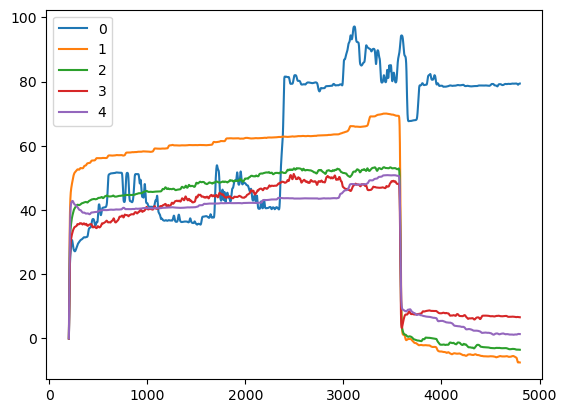

In [44]:
fig, ax  = plt.subplots(1,1)
for i in df_final.groupby(['tag_mg', "timestamps"]).mean().reset_index().groupby(["tag_mg"]):
    data = i[1]
    ax.plot(data["timestamps"], data["r"], label = i[0])

ax.legend()

# Blank Measurement

Text(0, 0.5, 'B (T)')

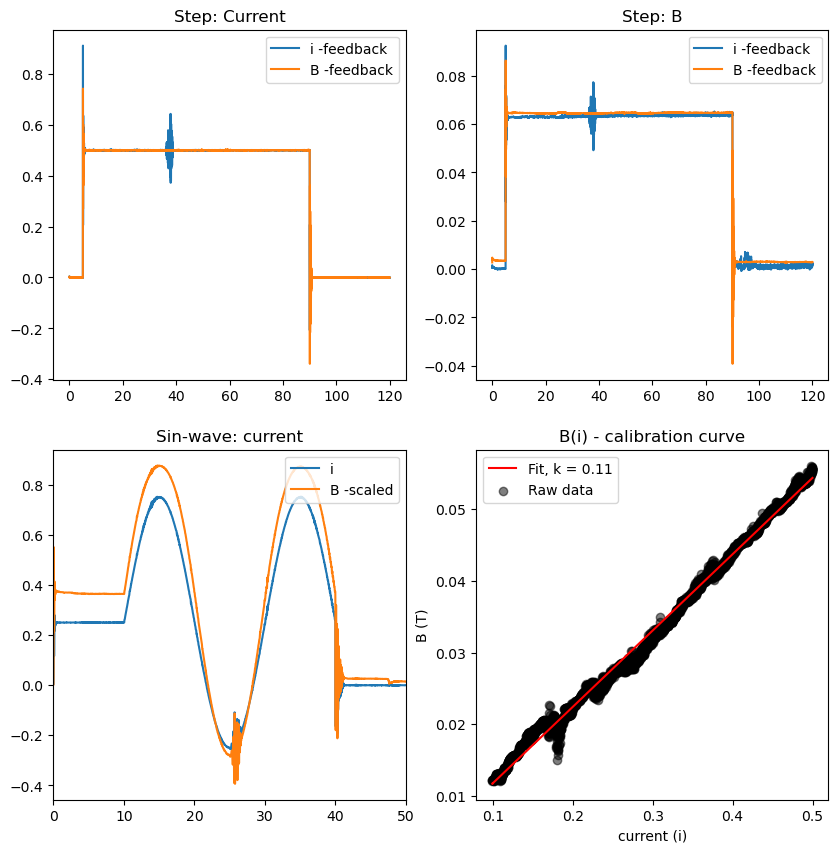

In [17]:
core = "./data/231024"

root = os.path.join(core,"231024_01_no_tracking/driver_2023-10-24.npy")
df = pd.DataFrame(np.load(root).T, columns = ['index','aim','measured','Mg', 'scaler'])

fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0]. set_title("Step: Current")
ax[0,0].plot(df["index"],df["measured"], label = "i -feedback")

ax[0,1]. set_title("Step: B")
ax[0,1].plot(df["index"],df["Mg"], label = "i -feedback")

root = os.path.join(core,"231024_01_B/driver_2023-10-24.npy")
df = pd.DataFrame(np.load(root).T, columns = ['index','aim','measured','Mg', 'scaler'])

ax[0,0].plot(df["index"],df["measured"], label = "B -feedback")
ax[0,1].plot(df["index"],df["Mg"], label = "B -feedback")

ax[0,0].legend()
ax[0,1].legend()

root = os.path.join(core,"231024_sinWave/driver_2023-10-24.npy")
df = pd.DataFrame(np.load(root).T, columns = ['index','aim','measured','Mg', 'scaler'])

ax[1,0].set_title("Sin-wave: current")
ax[1,1].set_title("Calibration")
ax[1,0].plot(df["index"],df["measured"], label = "i")
ax[1,0].plot(df["index"],df["Mg"]*10, label = "B -scaled")
ax[1,0].set_xlim([0,50])
ax[1,0].legend(loc = "upper right")

root = os.path.join(core,"231024_01_calibration/calib_2023-10-24.npy")
df = pd.DataFrame(np.load(root).T, columns = ['index','aim','measured','Mg', 'scaler'])
x, y, k, b, cut_off, max_index = fit_calibration(df)
ax[1,1].plot(x,k*x+b, label = "Fit, k = {}".format(np.round(k,2)), color = "red")
ax[1,1].scatter(x,y, label = "Raw data", alpha = 0.5, color = "black")
ax[1,1].legend()

ax[1,1].set_title("B(i) - calibration curve")
ax[1,1].set_xlabel("current (i)")
ax[1,1].set_ylabel("B (T)")


# Single particle

In [24]:
from cmdstanpy import CmdStanModel
import arviz as az

In [30]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def parse_dict(y_creep, y_rec, x_creep, x_rec, t_pred_creep, t_pred_rec, epsilon, t_c):

    stan_dict = {}
    stan_dict["n_creep"] = int(len(df["r"][start:end]))
    stan_dict["n_rec"] = int(len(df["r"][end:]))

    stan_dict["n_pred_creep"] = int(len(t_pred_creep))
    stan_dict["n_pred_rel"] = int(len(t_pred_rec))

    stan_dict["epsilon"] = float(epsilon)
    stan_dict["t_c"] = float(t_c)

    stan_dict["y_creep"] = df["r"][start:end].to_list()
    stan_dict["y_rec"] = df["r"][end:].to_list()

    stan_dict["x_creep"] = df["time"][start:end].to_list()
    stan_dict["x_rec"] = df["time"][end:].to_list()

    stan_dict["x_pred_creep"] = len(t_pred_creep)
    stan_dict["x_pred_rec"] = len(t_pred_rec)

    return stan_dict

start = int(5/(1/40))
end = int(90/(1/40))

df = df_track

df["r"] = normalize(df["r"])
df["time"] = normalize(df["time"])

t_hat_creep = df["time"][start:end]-df["time"].values[start]
t_hat_rec = df["time"][end:]-df["time"].values[start]

t_pred_creep = np.arange(t_hat_creep.min(),t_hat_creep.max(), 0.001)
t_pred_rec = np.arange(t_hat_rec.min(),t_hat_rec.max(), 0.001)

kirja = parse_dict( df["r"][start:end],  df["r"][end:], t_hat_creep, t_hat_rec, t_pred_creep, t_pred_rec, 1, 90)

with open('data.json','w') as f:
    json.dump(kirja,f)

model = CmdStanModel(stan_file='./stan/maxwell.stan')

fit = model.sample(data='data.json', adapt_delta=0.95, show_console=True) #

print(fit.diagnose())
fit.summary()

06:41:34 - cmdstanpy - INFO - compiling stan file F:\Git\MicrorheologyProto\stan\maxwell.stan to exe file F:\Git\MicrorheologyProto\stan\maxwell.exe
06:42:32 - cmdstanpy - INFO - compiled model executable: F:\Git\MicrorheologyProto\stan\maxwell.exe
06:42:32 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
06:42:32 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=F:/Git/MicrorheologyProto/stan/maxwell.hpp F:/Git/MicrorheologyProto/stan/maxwell.stan
Warning in 'F:/Git/MicrorheologyProto/stan/maxwell.stan', line 59, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'F:/Git/MicrorheologyProto/stan/maxwell.stan', line 60, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will 

Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 1000 (Default)
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.94999999999999996
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = data.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 12327
Chain [1] output
Chain [1] file = C:\Users\Arttu\App

RuntimeError: Error during sampling:
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=x_pred_creep; dims declared=(3400); dims found=() (in 'F:/Git/MicrorheologyProto/stan/maxwell.stan', line 25, column 4 to column 33)
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=x_pred_creep; dims declared=(3400); dims found=() (in 'F:/Git/MicrorheologyProto/stan/maxwell.stan', line 25, column 4 to column 33)
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=x_pred_creep; dims declared=(3400); dims found=() (in 'F:/Git/MicrorheologyProto/stan/maxwell.stan', line 25, column 4 to column 33)
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=x_pred_creep; dims declared=(3400); dims found=() (in 'F:/Git/MicrorheologyProto/stan/maxwell.stan', line 25, column 4 to column 33)
Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['F:\\Git\\MicrorheologyProto\\stan\\maxwell.exe', 'id=1', 'random', 'seed=12327', 'data', 'file=data.json', 'output', 'file=C:\\Users\\Arttu\\AppData\\Local\\Temp\\tmp2g25fk8w\\maxwellz_v6u8p5\\maxwell-20231031064232_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
 retcodes=[1, 1, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\Arttu\AppData\Local\Temp\tmp2g25fk8w\maxwellz_v6u8p5\maxwell-20231031064232_1.csv
 console_msgs (if any):
	C:\Users\Arttu\AppData\Local\Temp\tmp2g25fk8w\maxwellz_v6u8p5\maxwell-20231031064232_0-stdout.txt
Consider re-running with show_console=True if the above output is unclear!

In [31]:
azOut = az.from_cmdstanpy(posterior=fit,
                            posterior_predictive='y_pred_creep',
                            log_likelihood='log_lik_creep',
                            observed_data={'y_creep': kirja["y_creep"] })

AttributeError: type object 'fit' has no attribute 'column_names'

In [20]:
df_track

,x,y,t,time,r
0,0.110217,0.093277,0,0.000,0.144389
1,0.109547,0.093121,1,0.025,0.143778
2,0.108364,0.092718,2,0.050,0.142616
3,0.106504,0.092072,3,0.075,0.140784
4,0.103791,0.091188,4,0.100,0.138159
...,...,...,...,...,...
4795,1.483099,0.583278,4795,119.875,1.593674
4796,1.479824,0.597604,4796,119.900,1.595935
4797,1.477309,0.610115,4797,119.925,1.598338
4798,1.475591,0.619378,4798,119.950,1.600311


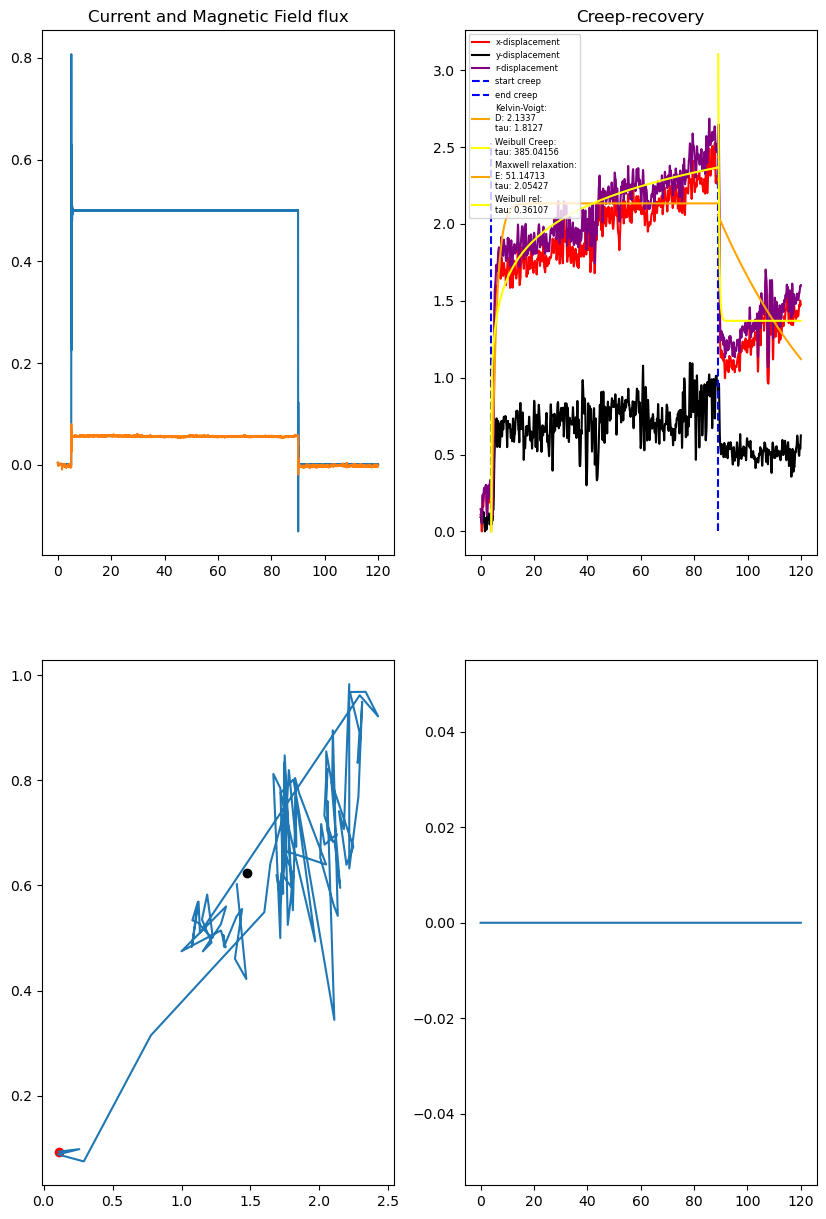

In [20]:
root = os.path.join(core,"231024_01_tracking/driver_2023-10-24.npy")
df = pd.DataFrame(np.load(root).T, columns = ['index','aim','measured','Mg', 'scaler'])

path_track = os.path.join(core,"231024_01_tracking/trackingData_2023-10-24.pickle")

with open(path_track, "rb") as input_file:
    file_track = cPickle.load(input_file)
    
df_track = pd.DataFrame.from_dict(file_track)


start = 40*4
end = 40*89

df_track["time"] = df_track["t"]*1/40

df_track["x"] = scipy.signal.detrend(scipy.ndimage.gaussian_filter(df_track["x"].max()-df_track["x"],5))
df_track["y"] = scipy.signal.detrend(scipy.ndimage.gaussian_filter(df_track["y"],5))
df_track["x"] -= df_track["x"].min()
df_track["y"] -= df_track["y"].min()
df_track["r"] = np.sqrt(df_track["x"]**2 + df_track["y"]**2)

fig, ax = plt.subplots(2,2, figsize=(10,15))

ax[0,0]. set_title("Current and Magnetic Field flux")
ax[0,0].plot(df["index"],df["measured"])
ax[0,0].plot(df["index"],df["Mg"])

ax[0,1].set_title("Creep-recovery")
ax[0,1].plot(df_track["time"],df_track["x"], color = "red", label = "x-displacement")
ax[0,1].plot(df_track["time"],df_track["y"], color = "black",label = "y-displacement")
ax[0,1].plot(df_track["time"],df_track["r"], color = "purple", label = "r-displacement")

ax[0,1].vlines(start*(1/40), df_track["x"].min(), df_track["x"].max(), color = "blue", label = "start creep", linestyle = "dashed")
ax[0,1].vlines(end*(1/40), df_track["x"].min(), df_track["x"].max(), color = "blue", label = "end creep", linestyle = "dashed")

t_hat = np.arange(df_track["time"][start:end].min(),df_track["time"][start:end].max(), 0.001)
p, p_ = curve_fit(kelvin, df_track["time"][start:end]-df_track["time"][start:end].values[0], df_track["r"][start:end], method = "dogbox")
creep_label = "Kelvin-Voigt:\nD: {}\ntau: {}".format(np.round(p[1],5),np.round(p[0],5))
ax[0,1].plot(t_hat, kelvin(t_hat-t_hat[0],*p), label = creep_label, color = "orange")

p, p_ = curve_fit(Weibull_creep, df_track["time"][start:end]-df_track["time"][start:end].values[0], df_track["r"][start:end],  bounds=([0, 0, 0, 0], [np.inf, np.inf, 1, np.inf]), method = "dogbox")
creep_label = "Weibull Creep: \ntau: {}".format(np.round(p[-1],5))
ax[0,1].plot(t_hat, Weibull_creep(t_hat-t_hat[0],*p), label = creep_label, color = "yellow")


rel_x = df_track["r"][end:].values
t_hat_rel = np.arange(df_track["time"][end:].min(),df_track["time"][end:].max(), 0.001)
p, p_ = curve_fit(maxwell_rel, df_track["time"][end:] - df_track["time"][end:].values[0], df_track["r"][end:], bounds=([rel_x[0]*0.8,0], [rel_x[0]*1.2, 1e3]), maxfev = 10000)
rel_label = "Maxwell relaxation:\nE: {}\ntau: {}".format(np.round(p[1],5),np.round(p[0],5)) 
ax[0,1].plot(t_hat_rel, maxwell_rel(t_hat_rel-t_hat_rel[0],*p), label = rel_label, color = "orange")

p, p_ = curve_fit(Weibull_rel, df_track["time"][end:] - df_track["time"][end:].values[0], df_track["r"][end:], bounds=([0, 0, 0, 0], [np.inf, np.inf, 1, np.inf]),maxfev = 10000)
rel_label = "Weibull rel:\ntau: {}".format(np.round(p[-1],5)) 
ax[0,1].plot(t_hat_rel, Weibull_rel(t_hat_rel-t_hat_rel[0],*p), label = rel_label, color = "yellow")

ax[0,1].legend(loc = "upper left",fontsize = 6)

ax[1,0].plot(df_track["x"][::50],df_track["y"][::50])
ax[1,0].scatter(df_track["x"][0],df_track["y"][0], color = "red")
ax[1,0].scatter(df_track["x"].values[-1],df_track["y"].values[-1], color = "black")

ax[1,1].plot(df["index"],df["scaler"])

Text(0, 0.5, ' $\\epsilon$ ($\\mu$m)')

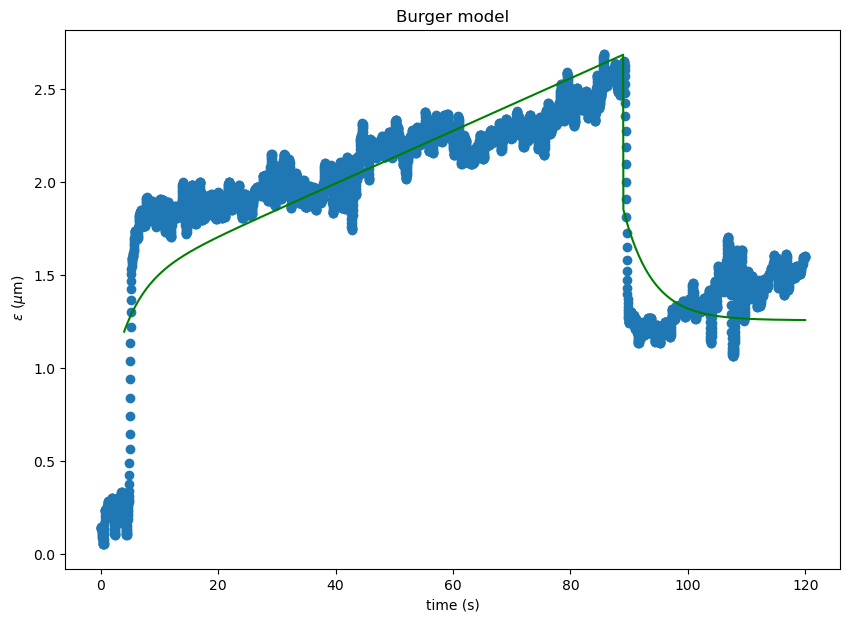

In [22]:
#def Weibull_rel(x, e_r, e_f, beta, tau):
#    return e_f + e_r*(np.exp(-(x/tau)**beta))
from scipy.optimize import curve_fit

class burger():

    def __init__(self, t_c, epsilon, start, end):
        self.epsilon_0 = epsilon
        self.t_c = t_c
        self.end = end
        self.start = start

    def burger_creep(self, x, E_1, E_2, n_1, n_2):
        return 1/E_1 + x/n_1 + 1/E_2*(1-np.exp(-x*E_1/n_2))
        
    def burger_rel(self, x,E_1, E_2, n_1, n_2):
        return self.t_c/n_1*(1-np.exp(-(x-self.t_c)*(E_2/n_2))) + (self.epsilon_0-1/E_1)*np.exp(-(x-self.t_c)*(E_2/n_2))
    
    def combined(self, x_tot, E_1, E_2, n_1, n_2):
        # single data reference passed in, extract separate data
        extract1 = x_tot[:end] # first data
        extract2 = x_tot[end:] # second data

        result1 = self.burger_creep(extract1, E_1, E_2, n_1, n_2)
        result2 = self.burger_rel(extract2, E_1, E_2, n_1, n_2)

        return np.append(result1, result2)
    
fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.scatter(df_track["time"],df_track["r"])

t_creep_hat = np.arange(df_track["time"][start:end].min(),df_track["time"][start:end].max(), 0.001)
t_rel_hat = np.arange(df_track["time"][end:].min(),df_track["time"][end:].max(), 0.001)
b_model = burger(df_track["time"].values[end],np.mean(df_track["r"].values[end-20:end]), start, end)

# curve fit the combined data to the combined function
p, pcov = curve_fit(b_model.combined, df_track["time"].values, df_track["r"].values, maxfev = 100000)
ax.plot(np.append(t_creep_hat,t_rel_hat), np.append(b_model.burger_creep(t_creep_hat,*p), b_model.burger_rel(t_rel_hat,*p) ), color = "green")

ax.set_title("Burger model")
ax.set_xlabel("time (s)")
ax.set_ylabel(r" $\epsilon$ ($\mu$m)")



In [23]:
p, p_ = curve_fit(b_model.burger_creep, df_track["time"][start:end], df_track["r"][start:end], method = "dogbox")
creep_label = "Burger: \ntau: {}".format(np.round(p[-1]/p[1],5))
ax.plot(t_creep_hat, b_model.burger_creep(t_creep_hat,*p), label = creep_label, color = "green")

p, p_ = curve_fit(b_model.burger_rel, df_track["time"][end:], df_track["r"][end:], bounds=[[0,0,0,0],[np.inf,np.inf,np.inf,np.inf]], maxfev = 10000)
rel_label = "Maxwell relaxation:\nE: {}\ntau: {}".format(np.round(p[1],5),np.round(p[0],5)) 
ax.plot(t_rel_hat, b_model.burger_rel(t_rel_hat,*p), label = rel_label, color = "orange")

# With Model

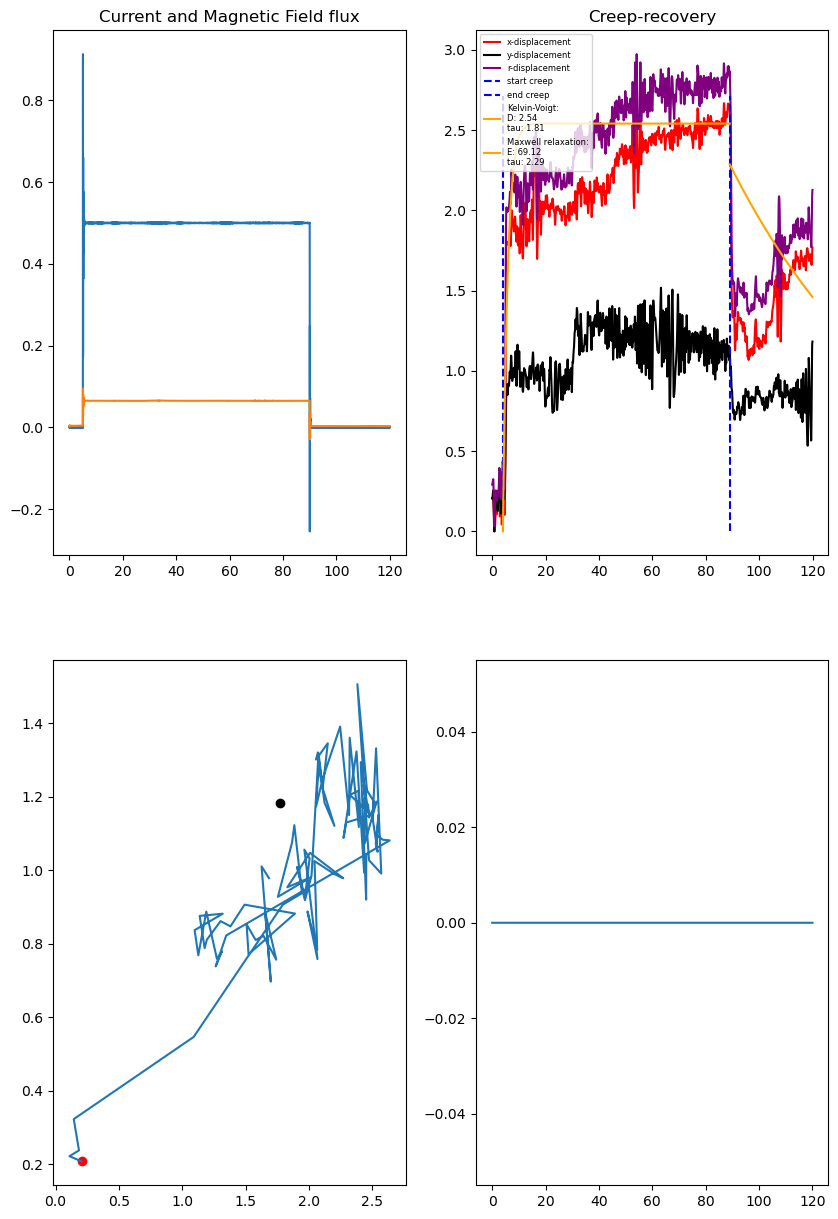

In [24]:
root = os.path.join(core,"231024_01_modeling/driver_2023-10-24.npy")
df = pd.DataFrame(np.load(root).T, columns = ['index','aim','measured','Mg', 'scaler'])

path_track = os.path.join(core,"231024_01_modeling/trackingData_2023-10-24.pickle")

with open(path_track, "rb") as input_file:
    file_track = cPickle.load(input_file)
df_track = pd.DataFrame.from_dict(file_track)


start = 40*4
end = 40*89

df_track["time"] = df_track["t"]*1/40
df_track["x"] = scipy.signal.detrend(scipy.ndimage.gaussian_filter(df_track["x"].max()-df_track["x"],5))
df_track["y"] = scipy.signal.detrend(scipy.ndimage.gaussian_filter(df_track["y"]-df_track["y"].min(),5))
df_track["x"] -= df_track["x"].min()
df_track["y"] -= df_track["y"].min()
df_track["r"] = np.sqrt(df_track["x"]**2 + df_track["y"]**2)

fig, ax = plt.subplots(2,2, figsize=(10,15))

ax[0,0]. set_title("Current and Magnetic Field flux")
ax[0,0].plot(df["index"],df["measured"])
ax[0,0].plot(df["index"],df["Mg"])

ax[0,1].set_title("Creep-recovery")
ax[0,1].plot(df_track["time"],df_track["x"], color = "red", label = "x-displacement")
ax[0,1].plot(df_track["time"],df_track["y"], color = "black",label = "y-displacement")
ax[0,1].plot(df_track["time"],df_track["r"], color = "purple", label = "r-displacement")

ax[0,1].vlines(start*(1/40), df_track["x"].min(), df_track["x"].max(), color = "blue", label = "start creep", linestyle = "dashed")
ax[0,1].vlines(end*(1/40), df_track["x"].min(), df_track["x"].max(), color = "blue", label = "end creep", linestyle = "dashed")


t_hat = np.arange(df_track["time"][start:end].min(),df_track["time"][start:end].max(), 0.001)
p, p_ = curve_fit(kelvin, df_track["time"][start:end]-df_track["time"][start:end].values[0], df_track["r"][start:end], method = "dogbox")
creep_label = "Kelvin-Voigt:\nD: {}\ntau: {}".format(np.round(p[1],2),np.round(p[0],2))
ax[0,1].plot(t_hat, kelvin(t_hat-t_hat[0],*p), label = creep_label, color = "orange")

rel_x = df_track["r"][end:].values
t_hat_rel = np.arange(df_track["time"][end:].min(),df_track["time"][end:].max(), 0.001)
p, p_ = curve_fit(maxwell_rel, df_track["time"][end:] - df_track["time"][end:].values[0], df_track["r"][end:], bounds=([rel_x[0]*0.8,0], [rel_x[0]*1.2, 1e3]), maxfev = 10000)
rel_label = "Maxwell relaxation:\nE: {}\ntau: {}".format(np.round(p[1],2),np.round(p[0],2)) 
ax[0,1].plot(t_hat_rel, maxwell_rel(t_hat_rel-t_hat_rel[0],*p), label = rel_label, color = "orange")
ax[0,1].legend(loc = "upper left",fontsize = 6)


ax[1,0].plot(df_track["x"][::50],df_track["y"][::50])
ax[1,0].scatter(df_track["x"][0],df_track["y"][0], color = "red")
ax[1,0].scatter(df_track["x"].values[-1],df_track["y"].values[-1], color = "black")

ax[1,1].plot(df["index"],df["scaler"])

(211001, 4)
(3025, 4)


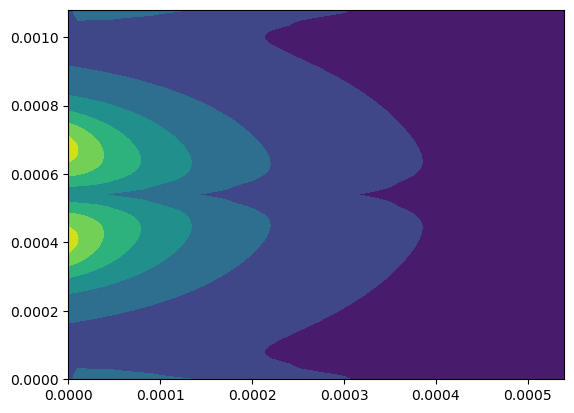

In [25]:
x = 0.0004258026478661925 
y = 0.0003758985538919442

root = "./data/One_coil.csv"
m = 3.5/(10*3.3*0.3)*1e-6
rot_matrix = np.array([[np.cos(-np.pi/2), -np.sin(-np.pi/2)],[np.sin(-np.pi/2), np.cos(-np.pi/2)]])

df = pd.read_csv(root, sep = ",", skiprows= [0,1], names = ["x", "y", "By", "Bx"])
#drop not needed
print(df.shape)
df.drop(df[df["y"].values < (0.0035 - 1536*m)].index, inplace = True)
df.drop(df[df["x"].values > 0.00054].index, inplace = True)
print(df.shape)


df["Bx"] = scipy.ndimage.gaussian_filter1d(df["Bx"].values,5)
df["By"] = scipy.ndimage.gaussian_filter1d(df["By"].values,5)

df["x"] = np.round(df["x"],5)
df["y"] = np.round(df["y"],5)

map_Bx = df["Bx"].values
map_By = df["By"].values

B = np.sqrt(map_Bx**2 + map_By**2)

map_x = df["x"].values
map_y = df["y"].values

mg_idx = np.where((map_x == np.round(x,5)) & (map_y == np.round(y,5)))
cB  = np.sqrt(map_Bx[mg_idx]**2 + map_By[mg_idx]**2)

xx = (np.max(map_y) - map_y).reshape( len(np.unique(map_x)), len(np.unique(map_y)) )
yy = map_x.reshape(len(np.unique(map_x)), len(np.unique(map_y)))
B = B.reshape(len(np.unique(map_x)), len(np.unique(map_y)))

xx_ = np.hstack((xx,xx))
yy_ = np.hstack((-yy[:,::-1], yy))
yy_ -= yy_.min() 
xx_ = np.round(xx_,5)
yy = np.round(yy_,5)

bb_ = np.hstack((B[:,::-1], B))


plt.contourf(xx_, yy_, bb_)


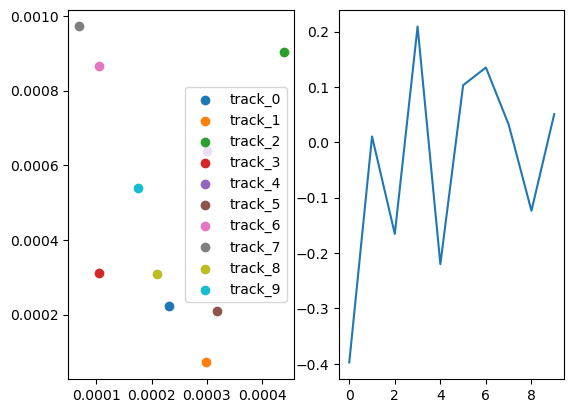

In [82]:
prev_ = 0

steps = 10
errors = np.zeros(steps)

rows = np.unique(xx_)
columns = np.unique(yy_)

fig, ax  = plt.subplots(1,2)
for i in range(steps):
    x = np.random.uniform(np.min(xx_),np.max(xx_))
    y = np.random.uniform(np.min(yy_),np.max(yy_))
    ax[0].scatter(x,y, label = "track_{}".format(i))
    x_idx = np.argmin(np.abs((rows-np.round(x,5))))
    y_idx = np.argmin(np.abs((columns-np.round(y,5))))
    try:
        current = bb_[x_idx, y_idx]
    except:
        print("failed", np.round(x,5), np.round(y,5))
        print("resutls: ",np.where((xx_ == np.round(x,5)) & (yy_ == np.round(y,5))))

        current = prev_
        
    errors[i] = prev_ - current
    prev_ = current

ax[1].plot(errors)

ax[0].legend()



In [80]:
x_idx = np.argmin(np.abs((np.unique(xx_)-np.round(x,5))))
y_idx = np.argmin(np.abs((np.unique(yy_)-np.round(y,5))))

bb_[x_idx,y_idx]


0.37305045294240863

In [54]:
xx_

array([[5.4e-04, 5.4e-04, 5.4e-04, ..., 5.4e-04, 5.4e-04, 5.4e-04],
       [5.3e-04, 5.3e-04, 5.3e-04, ..., 5.3e-04, 5.3e-04, 5.3e-04],
       [5.2e-04, 5.2e-04, 5.2e-04, ..., 5.2e-04, 5.2e-04, 5.2e-04],
       ...,
       [2.0e-05, 2.0e-05, 2.0e-05, ..., 2.0e-05, 2.0e-05, 2.0e-05],
       [1.0e-05, 1.0e-05, 1.0e-05, ..., 1.0e-05, 1.0e-05, 1.0e-05],
       [0.0e+00, 0.0e+00, 0.0e+00, ..., 0.0e+00, 0.0e+00, 0.0e+00]])

FileNotFoundError: [Errno 2] No such file or directory: './data/calib/calib_2023-10-20.npy'

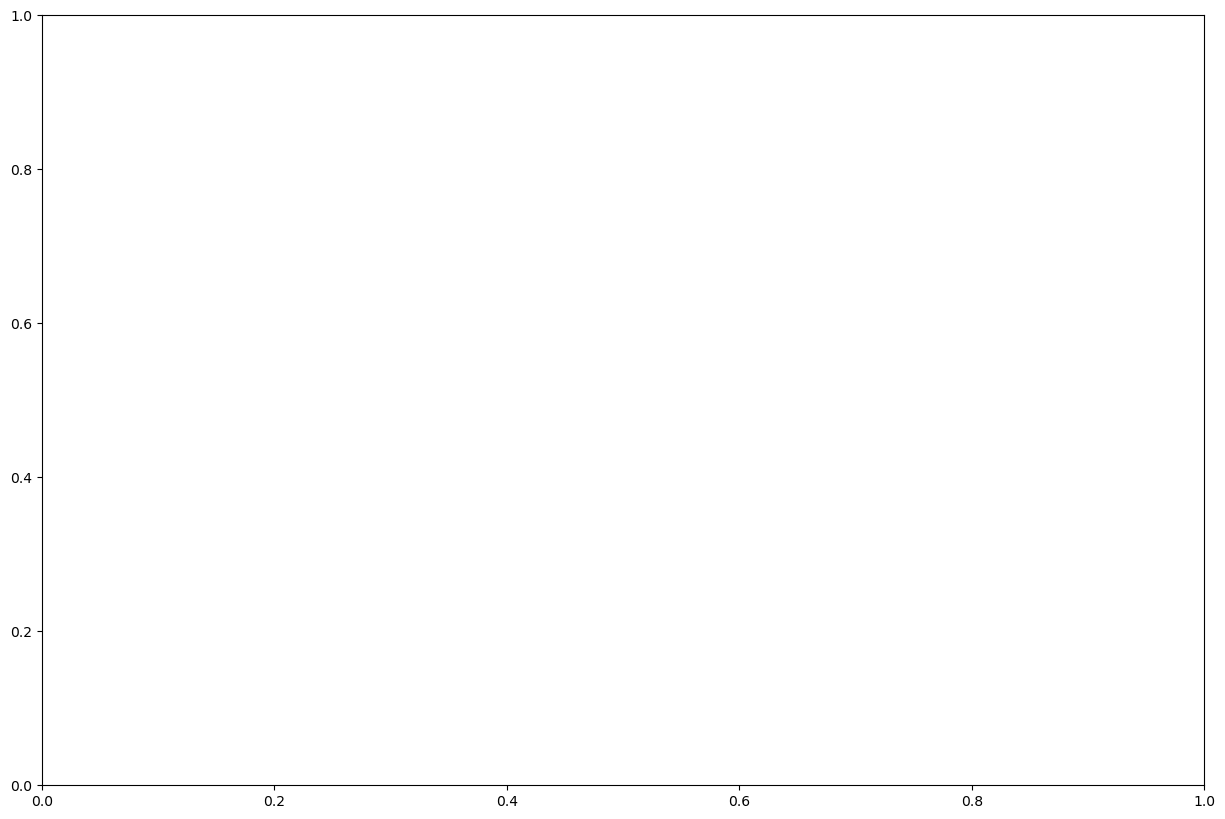

In [6]:
#load Calibration
fig, ax = plt.subplots(1, 1, figsize = (15,10))

patH = "./data/calib/calib_2023-10-20.npy"
df = pd.DataFrame(np.load(patH).T, columns = ['index','aim','measured','Mg', 'scaler'])
x, y, k, b, cut_min, cut_max = fit_calibration(df)

ax.plot(np.arange(np.min(x),np.max(x),1e-2),k*np.arange(np.min(x),np.max(x),1e-2)+b,color = "red", label = "Fit, k = {}".format(np.round(k,2)))
ax.scatter(x,y, color = "black", label = "Hall -sensor")


datapath = glob("./data/calib/*.csv")
Gauss = fetchDataCSV(datapath)
Gauss = Gauss.reset_index()
Gauss["GUSS_ValueNP"] *= 1e-4
df_g =Gauss.loc[cut_min/100:cut_max/100,:].reset_index()  

ax.scatter( x[::100], df_g["GUSS_ValueNP"]+b, label = "Gaussmeter (scaled)")

ax.legend()
ax.set_title("B(i) - calibration curve")
ax.set_xlabel("current (i)")
ax.set_ylabel("B (T)")

In [7]:
cut_min

NameError: name 'cut_min' is not defined

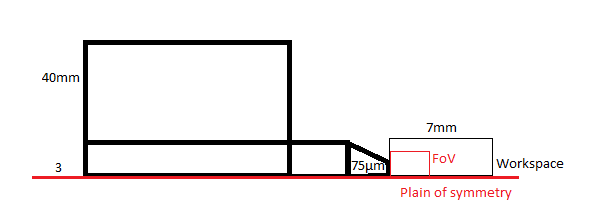

Force experienced by a magnetic bead in an external non-homogenous B. Here, we focus on 2D problem since microscope FoV limits observations to 2D projections.

$
\begin{align}
F_{bead} &= V \cdot M(B) \cdot \nabla B(x,y)
\end{align}
$

M - Magnetization of the bead (A/m), V - volume of the bead ($m^3$), and $\nabla$ B - magnetic field gradient. 

B depends on directly on i linearly or non-linearly depending on the core properties. Constant core permeability gives linear dependence between B and i$_input$ whereas B-H based core permeability suggests non-linear dependence which saturates at certain input current levels.

B is simulated using Comsol and Gaussian current loop technique. From Comsol: \textbf{B}(x,y,i = 0.5 A) and direction angle $\alpha$. From this $\nabla B_x$ and $\nabla B_y$ were derived and sampled based on {x,y} coordinates in the calculations. The spatial density of the simulation was 0.05mm ( $\partial x = \partial y = 5 \cdot 10^{-5}$)

$
\begin{align}
B_x &= B \cos( \alpha ) \\
B_y &= B \sin( \alpha ) \\
\nabla B &= [\frac{ \partial |B|}{\partial x}, \frac{ \partial |B|}{\partial y} ]
\end{align}
$

M(B) can be derived from magnetization measurements which give magnetic moment ($m$) as a function of magnetic field intensity ($H$). Here, we calculate both mass and volumetric magnetization. Mass magnetization is used to compare with tds and volumetric in calculations.

$
\begin{align}
M_{\text{mass}} &= \frac{m}{mass} \\
M_{\text{volumetric}} &= \frac{m}{V}
\end{align}
$

A displacement model for a magnetic bead was used to simulate the bead dispalcement in the field. Both x and y coordinates were managed independently.

k - number of timestep
dt - length of timestep
$\rho$ - density
s$_{k, \text{bead}}$ - bead position
v$_{k, \text{bead}}$ - bead velocity
a$_{k, \text{bead}}$ - bead acceleration

$
\begin{align}
f_{\text{bead}} &= mass \cdot a \rightarrow a = \frac{f_{\text{bead}}}{mass} = \frac{f_{\text{bead}}}{\rho \cdot V_{\text{bead}}} \\
s_{k, \text{bead}}  &= s_{k-1, \text{bead}} + v_{k-1, \text{bead}}*dt + \frac{f}{m}*dt^2 \\
v_{k, \text{bead}} &= v_{k-1, \text{bead}} + \frac{f}{m}*dt \\
\end{align}
$


Mechanocal pareameters were derived from simulated and experimental displacement data using 1) classical micromechnical models 1.0) without B adjustment and 1.1) with B adjustment. Without B adjustment moving bead do not experience constant magnetic gradient since nonhomogenous B. Here, assumptions of constant force in previous studies are evaluated.

Creep:

kelvin-Voigt model and burger model:

$
\begin{align}
\epsilon_{\text{Kelvin-Voigt}} (t) &= \frac{1}{E}*(1-e^{\frac{-E t}{n}}) \\
\epsilon_{\text{Burger's}} (t) &= \sigma \left( \frac{1}{E_1} + \frac{t}{n_1} + \frac{1}{E_2} (1 - e^{ \frac{-E_2 t}{n_2}}) \right)
\end{align}
$

Relaxation:

maxwell model and burger model:

$
\begin{align}
\epsilon_{\text{Kelvin-Voigt}} (t) &= E e^{ \frac{- E t}{n}} \\
\epsilon_{\text{Burger's}} (t) &= 
\end{align}
$

Response to 

1) I - Step with current feedback and Step with B feedback
2) B - Step with current feedback and Step with B feedback
2) Sin wave with current feedback and Step with B feedback
3) Calibration slope between B and current and Magnetic sensor



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

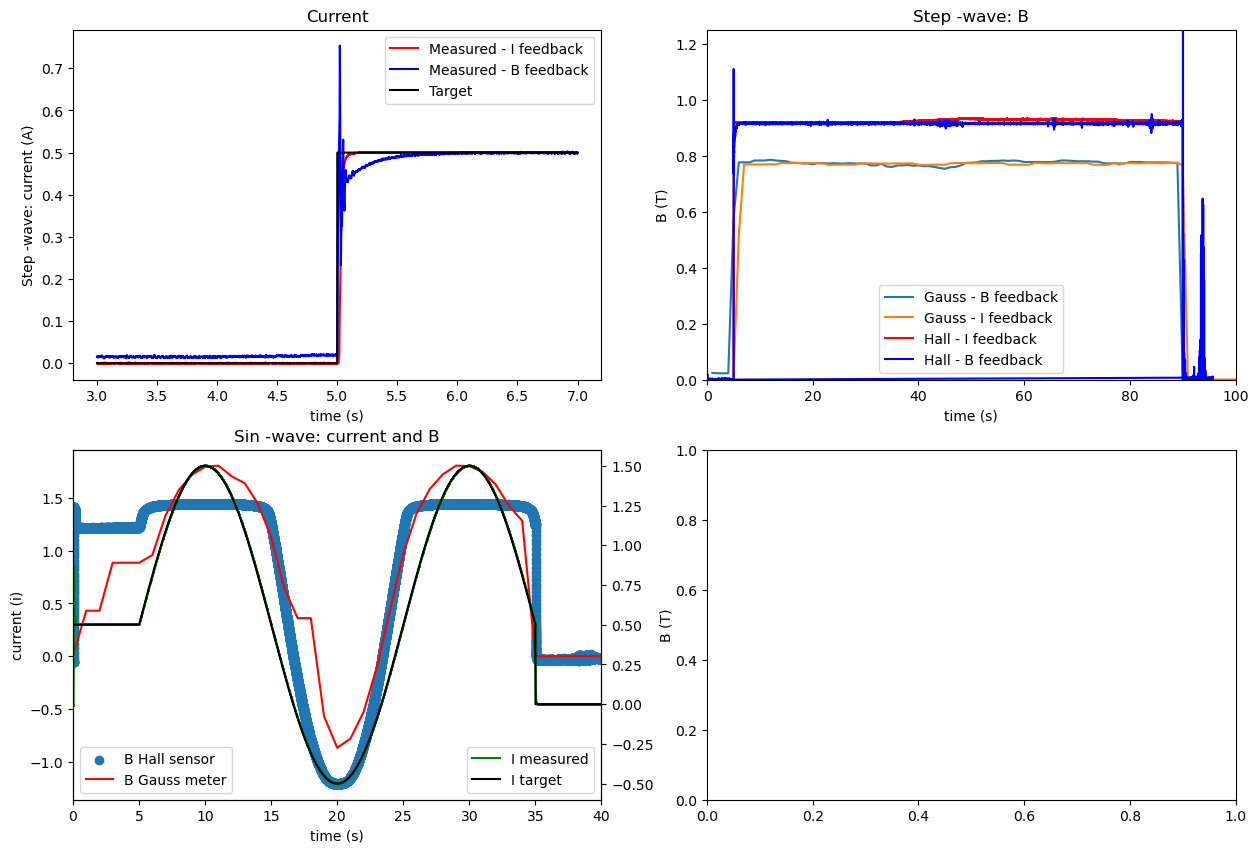

In [5]:
#Load Mg Step
pathH = "./data/M1_StepB.npy"
pathG = "./data/M1_StepB.csv"

MgHall = pd.DataFrame(np.load(pathH).T, columns = ['index','aim','measured','Mg'])
MgGauss = pd.read_csv(pathG, index_col = False)

#Load I step

pathH = "./data/M1_StepCurrent.npy"
pathG = "./data/M1_StepCurrent.csv"

CurrentHall = pd.DataFrame(np.load(pathH).T, columns = ['index','aim','measured','Mg'])
CurrentGauss = pd.read_csv(pathG, index_col = False)

MgGauss["GUSS_ValueNP"] = MgGauss["GUSS_ValueNP"]*1e-3
CurrentGauss["GUSS_ValueNP"] = CurrentGauss["GUSS_ValueNP"]*1e-3



fig, ax  = plt.subplots(2, 2, figsize = (15,10))

start = 3000
end = 7000

target = np.ones(end-start)*0.68
target[:2000] = 0

ax[0,0].set_title("Current")

ax[0,0].plot(CurrentHall["index"][start:end],CurrentHall["measured"][start:end], color = "red", label = "Measured - I feedback")
ax[0,0].plot(MgHall["index"][start:end],MgHall["measured"][start:end]*1.35, color = "blue", label = "Measured - B feedback")
ax[0,0].plot(CurrentHall["index"][start:end],CurrentHall["aim"][start:end], color = "black", label = "Target")

ax[0,0].set_ylabel("Step -wave: current (A)")
ax[0,0].set_xlabel("time (s)")
ax[0,0].legend()


ax[0,1].plot(MgGauss["Idx"],MgGauss["GUSS_ValueNP"]*1.35, label = "Gauss - B feedback")
ax[0,1].plot(CurrentGauss["Idx"],CurrentGauss["GUSS_ValueNP"], label = "Gauss - I feedback")

ax[0,1].plot(CurrentHall["index"],CurrentHall["Mg"], color = "red", label = "Hall - I feedback")
ax[0,1].plot(MgHall["index"],MgHall["Mg"]*1.35, color = "blue", label = "Hall - B feedback")

ax[0,1].set_xlim([0,100])
ax[0,1].set_ylim([0,1.25])

ax[0,1].set_title("Step -wave: B")
ax[0,1].set_ylabel("B (T)")
ax[0,1].set_xlabel("time (s)")
ax[0,1].legend()

#Load sin wave
dataBd = "./data/sinWave.csv"
datas = pd.read_csv(dataBd, index_col = False)

paths = "./data/sinWave.npy"
df = pd.DataFrame(np.load(paths).T, columns = ['index','aim','measured','Mg'])

datas["GUSS_Value"] = datas["GUSS_Value"]*(-1)
df["Mg"] = df["Mg"]

ax[1,0].scatter(df["index"],df["Mg"], label = "B Hall sensor")
ax[1,0].plot(datas["Idx"]-8, datas["GUSS_Value"]*1e-3, color = "red", label = "B Gauss meter")

ax[1,0].set_xlim([0,40])
ax_twin = ax[1,0].twinx()

num = 50000
ax_twin.plot(df["index"][:-num],df["measured"][:-num], color = "green", label = "I measured")
ax_twin.plot(df["index"][:-num], df["aim"][:-num], color = "black", label = "I target")


ax[1,0].set_title("Sin -wave: current and B")
ax[1,0].set_xlabel("time (s)")
ax[1,0].set_ylabel("current (i)")
ax[1,0].legend(loc = "lower left")

ax_twin.set_xlabel("time (s)")
ax_twin.set_ylabel("B (T)")
ax_twin.legend(loc = "lower right")


#load Calibration
patH = "./data/calibration_example.npy"
df = pd.DataFrame(np.load(patH).T, columns = ['index','aim','measured','Mg'])
B_coef, x, y, k = fit_calibration(np.load(patH))

ax[1,1].plot(np.arange(0,np.max(x),1e-2),k*np.arange(0,np.max(x),1e-2), label = "Fit, k = {}".format(np.round(k[0],2)))
ax[1,1].scatter(df["measured"]-df["measured"][0], df["Mg"]-df["Mg"][0], label = "Raw data")
ax[1,1].legend()

ax[1,1].set_title("B(i) - calibration curve")
ax[1,1].set_xlabel("current (i)")
ax[1,1].set_ylabel("B (T)")



Core extension dependence (Linearity) 

Dependence of magnetic field and sensor distance

(0.0, 115.0)

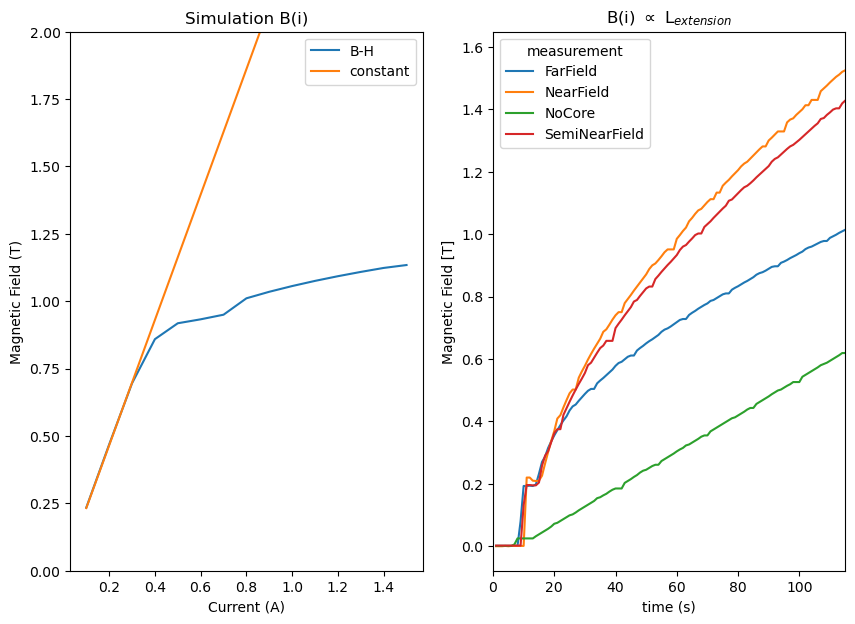

In [6]:
file =  "./data/One_coil_slope_constant.csv"
df = pd.read_csv(file, sep = ",", skiprows= range(9), names = ["t", "B"])
df["type"] = "constant"

file =  "./data/One_coil_slope.csv"
df_sub = pd.read_csv(file, sep = ",", skiprows= range(9), names = ["t", "B"])
df_sub["type"] = "B-H"
df = pd.concat((df,df_sub))

fig, ax  = plt.subplots(1, 2, figsize = (10,7))

types = df["type"].unique()

k= 0.1

for count,i in enumerate(df.groupby("type")):
    name, i = i
    ax[0].plot(k*i["t"].values, i["B"].values, label = name)

ax[0].legend()
ax[0].set_ylim([0,2])
ax[0].set_xlabel("Current (A)")
ax[0].set_ylabel("Magnetic Field (T)")
ax[0].set_title("Simulation B(i)")


datapath = glob("./data/extension_calib/*.csv")
Gauss = fetchDataCSV(datapath)
Gauss = Gauss.reset_index()
Gauss["GUSS_ValueNP"] *= 1e-3

sns.lineplot(data = Gauss, x = "Idx", y = "GUSS_ValueNP", hue = "measurement", ax = ax[1])

ax[1].set_title(r'B(i) $ \propto $ L$_{extension}$')
ax[1].set_ylabel("Magnetic Field [T]")
ax[1].set_xlabel("time (s)")
ax[1].set_xlim([0,115])

Single Particle tracker - Step 

1) Displacement (without and with linear feedback)
2) Estimated feedback value as function of time
3) Current with feedback
4) Magnetic field with feedback
5) simulation of particle displacements

***Need real measurements from the core***

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TypeError: unsupported operand type(s) for +: 'int' and 'str'

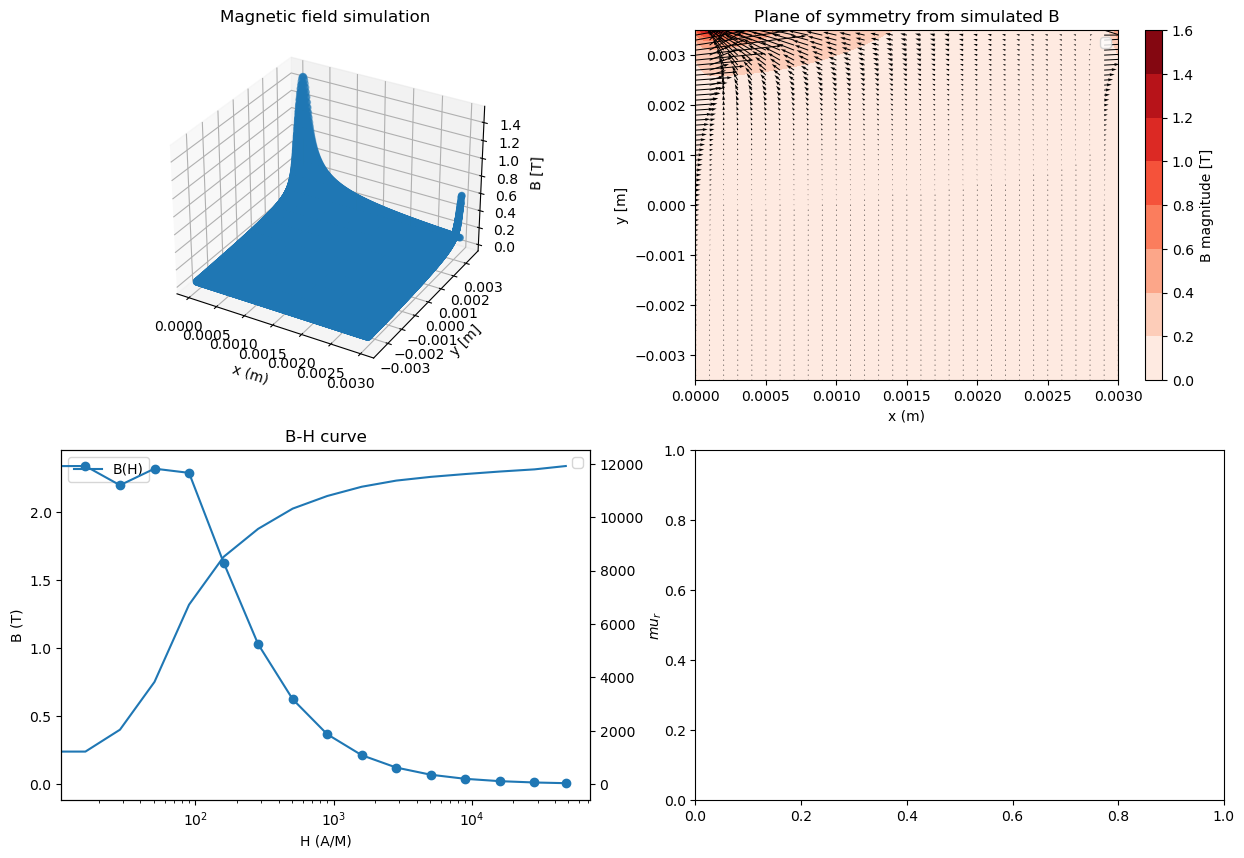

In [10]:
file =  "./data/One_coil.csv"

df = pd.read_csv(file, sep = ",", skiprows= [0,1], names = ["x", "y", "By", "Bx"])

#df["y"] -= max(df["y"].values)
#df["y"] = np.abs(df["y"])

df["x"] = np.round(df["x"],5)
df["y"] = np.round(df["y"],5)

df["Bx"] = scipy.ndimage.gaussian_filter1d(df["Bx"].values,5)
df["By"] = scipy.ndimage.gaussian_filter1d(df["By"].values,5)

fig,ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,10))

ax[0,0].remove()
ax[0,0]=fig.add_subplot(2,2,1,projection='3d')
ax[0,0].scatter(df["x"], df["y"], np.sqrt(df["By"]**2 + df["Bx"]**2))
ax[0,0].set_xlabel("x (m)"); ax[0,0].set_ylabel("y [m]"); ax[0,0].set_zlabel("B [T]")
ax[0,0].set_title("Magnetic field simulation")


df["B"] = np.sqrt(df["By"]**2 + df["Bx"]**2)

df["angle"] = np.arctan2(df["Bx"], df["By"])

coord_x = df["x"].unique()
coord_y = df["y"].unique()

xx, yy = np.meshgrid(coord_x, coord_y)

data = np.array(df["B"].values).reshape(len(coord_y),len(coord_x))

data_x = np.array(df["Bx"].values).reshape(len(coord_y),len(coord_x))
data_y = np.array(df["By"].values).reshape(len(coord_y),len(coord_x))

angle = np.array(df["angle"].values).reshape(len(coord_y),len(coord_x))

h = ax[0,1].contourf(xx, yy, data, cmap = "Reds")
cbar = fig.colorbar(h, label = "B magnitude [T]")

dBx = scipy.ndimage.gaussian_filter(np.gradient(data, (1e-5), axis  = 0),5)#*np.sin(angle)
dBy = scipy.ndimage.gaussian_filter(np.gradient(data, (1e-5), axis  = 1),5)#*np.cos(angle)

phase = 10
ax[0,1].quiver(xx[::phase, ::phase], yy[::phase,::phase], dBy[::phase,::phase], dBx[::phase,::phase], angles = "xy") #dBy[::phase,::phase],dBx[::phase,::phase]

ax[0,1].set_title("Plane of symmetry from simulated B")
ax[0,1].set_xlabel("x (m)"); ax[0,1].set_ylabel("y [m]")
ax[0,1].legend()

df_sim = df 


#B-H curve B = \mu_0*(H+M)

df = pd.read_csv("./data/core_H_B.csv", sep= ",")
df["mu"] = df["B"]/(df["H"]*(1.25663706212e-6))
df["mu"][0] = 0

ax[1,0].plot(df["H"],df["B"], label = "B(H)")
ax[1,0].set_xlabel("H (A/M)")
ax[1,0].set_ylabel("B (T)")
ax[1,0].set_title("B-H curve")
ax[1,0].set_xscale("log")

ax_1 = ax[1,0].twinx()
ax_1.plot(df["H"],df["mu"])
ax_1.scatter(df["H"],df["mu"])
ax_1.set_ylabel(r"$mu_r$")

ax[1,0].legend()
ax_1.legend()

# Units https://www.nist.gov/system/files/documents/pml/electromagnetics/magnetics/magnetic_units.pdf
paths = glob("./data/*.dat")

#These are magnetization values for the beads for micromod data sheet
mgM = np.array([-6.6, -4.3, 0, 4.3, 6.6]) #Mass magnetization
mgH = np.array([-800e3, -80e3, 0, 80e3, 800e3])

for count,i in enumerate(paths):
    end = i.split("\\")[1]
    parts = end.split("_")
    day = parts[0]
    size = float(parts[1][:-7])*1e-6
    weight = float(parts[2][:-6])*1e-8 #*0.0275

    df_sub = pd.read_csv(i, sep= ",", skiprows = np.arange(0,31)).iloc[1:, :].dropna(how='all', axis = "columns")
    df_sub["sample"] = count
    df_sub["size"] = size
    df_sub["weight"] = weight

    #Oe  1/(4pi)*10^3 A/m
    df_sub["H"] = df_sub["Magnetic Field (Oe)"] * 1/(4*np.pi)*1e3
    #= 1 emu 10−3 A·m2
    df_sub["moment"] = df_sub["Moment (emu)"]*1e-3

    start = np.where(df_sub["H"][:125].values>600e3)[0][0]

    end = np.argmax(df_sub["H"][:125].values)
    k = np.polyfit(df_sub["H"][start:end].values,df_sub["moment"][start:end].values-df_sub["moment"][start:end].values[0],deg = 1, cov = False)
    offset = k[0]*df_sub["H"]
    df_sub["moment"] = df_sub["moment"] - offset
    #print(weight)
    df_sub["M_mass"] = df_sub["moment"]/(weight)
    df_sub["M"] =  df_sub["moment"]/(4/3*np.pi*(size/2)**3) #A/m

    #plt.plot(df_sub["H"],df_sub["M_mass"], label = "measured sample {}".format(count))
    if count == 0:
        df =df_sub
    else:
        df = pd.concat((df,df_sub))


df["H_round"] = np.round(df["H"].values, -5)
fd_mean = df.groupby(["H_round"]).mean().reset_index()
error = df.groupby(["H_round"]).std()["M_mass"].values

ax[1,1].errorbar(fd_mean["H_round"],fd_mean["M_mass"], yerr = error)
ax[1,1].scatter(fd_mean["H_round"],fd_mean["M_mass"], label = "sample mean")
ax[1,1].scatter(mgH,mgM, color = "red", label = "Data Sheet")
xdata = np.linspace(-800000,800000,1000)
popt, pcov = curve_fit(func, mgH, mgM, bounds = [[0,1/100000],[8,1/5000]])
ax[1,1].plot(xdata, func(xdata, *popt),color = "red")
M = func(xdata, *popt)
ax[1,1].set_xlabel("H [A/m]")
ax[1,1].set_ylabel("Mass M [Am^2/kg]")
ax[1,1].set_title("Particle Mass magnetization")

ax[1,1].legend()

df_mag = df





In [ ]:
class particle:

    def __init__(self,x,y, dt, np_steps):
        self.s_x = x
        self.s_y = y

        self.v_x = 0
        self.v_y = 0

        self.step = 0

        self.position_history = np.zeros((2,np_steps))
        self.position_history[0,self.step] = self.s_x
        self.position_history[1,self.step] = self.s_y

        size = 30*1e-6
        rho = 1.3 * 1000 # kg/m^3

        V = 4/3*np.pi*(size/2)**3

        self.vis = 1

        self.m = rho*V*1e3
        self.dt = dt



    def new_pos(self,f_x, f_y):
        
        self.s_x = self.s_x + self.v_x*self.dt + f_x/self.m*self.dt**2
        print("stepping x", self.s_x + self.v_x*self.dt + f_x/self.m*self.dt**2)


        self.v_x =self.v_x + f_x/self.m*self.dt
    
        self.s_y = self.s_y + self.v_y*self.dt + f_y/self.m*self.dt**2
        self.v_y = self.v_y + f_y/self.m*self.dt

        print("stepping y", self.s_x + self.v_x*self.dt + f_x/self.m*self.dt**2)

        self.position_history[0,self.step] = self.s_x
        self.position_history[1,self.step] = self.s_y

    def add_drag(self, v):

        f_d = 3*np.pi*self.vis*size*v

        return -f_d

    def get_position(self):
        return self.s_x,self.s_y
    
    def add_noise(self):
        self.s_x +=  np.random.normal(0,1e-7)
        self.s_y +=  np.random.normal(0,1e-7)

    def get_history(self):
        return self.position_history

In [64]:
root = "./data/One_coil.csv"

df = pd.read_csv(root, sep = ",", skiprows= [0,1], names = ["x", "y", "By", "Bx"])

#drop not needed
df.drop(df[df["y"].values < (0.0035 - 1536*m)].index, inplace = True)
df.drop(df[df["x"].values > 0.00054].index, inplace = True)

B = np.sqrt(df["By"].values**2 + df["Bx"].values**2)

rows = df["x"].unique()
columns = df["y"].unique()

n_rows = len(rows)
n_columns = len(columns)

B = B.reshape(n_rows, n_columns)
B = np.hstack((B[:,::-1], B))

dBx = scipy.ndimage.gaussian_filter(np.gradient(B, (1e-5), axis  = 1),5)#*np.sin(angle)
dBy = -scipy.ndimage.gaussian_filter(np.gradient(B, (1e-5), axis  = 0),5)#*np.cos(angle)

xx = (np.max(map_y) - map_y).reshape(n_rows, n_columns)
yy = map_x.reshape(n_rows, n_columns)
xx_ = np.hstack((xx,xx))
yy_ = np.hstack((-yy[:,::-1], yy))
yy_ -= yy_.min() 

xx_ = np.round(xx_,5)
yy_ = np.round(yy_,5)



stepping x 0.00037729533966913216
stepping y 0.00037594300950369823
stepping x 0.00037323834917283037
stepping y 0.00037188601900739644
stepping x 0.00036782902851109465
stepping y 0.0003664766983456608
stepping x 0.00036114581313069364
stepping y 0.0003598327006886439
stepping x 0.0003531494853082428
stepping y 0.0003518363728661931
stepping x 0.0003439178261486075
stepping y 0.0003426436042589904
stepping x 0.00033348894708282016
stepping y 0.0003322532261849356
stepping x 0.00032190044409155657
stepping y 0.0003207027716798761
stepping x 0.00030918932212355263
stepping y 0.00030802917642934236
stepping x 0.0002953919086325899
stepping y 0.0002942686900240052
stepping x 0.00028054375898168226
stepping y 0.00027945678159741757
stepping x 0.00026474874256809526
stepping y 0.0002637318204946232
stepping x 0.00024800407592512585
stepping y 0.0002470207897736986
stepping x 0.00023040441299432648
stepping y 0.00022948527177469788
stepping x 0.00021194649260333689
stepping y 0.0002110577932

(0.0, 0.00108)

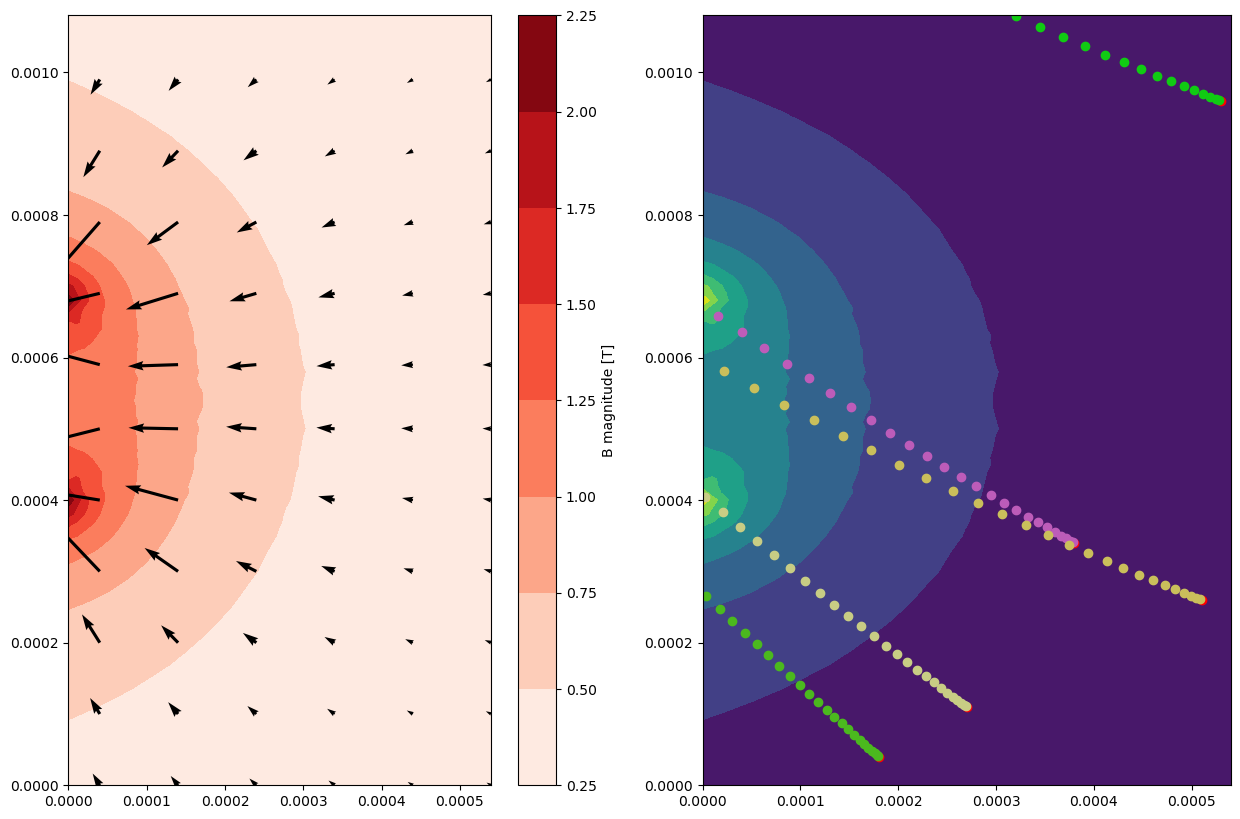

In [87]:
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10))



pixel_size = 3.5/(20*3.3*0.3)
FoV_x = np.max(xx_)
FoV_y = np.max(yy_)

mu_0 = 4*np.pi*1e-7

num_sim = 5
n_steps = 10
dt = 1e-10

beads = []

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(num_sim)]


h = ax[0].contourf(xx_, yy_, B, cmap = "Reds")
cbar = fig.colorbar(h, label = "B magnitude [T]")
ax[0].quiver(xx_[::phase, ::phase], yy_[::phase,::phase], dBy[::phase,::phase], dBx[::phase,::phase], angles = "xy") #dBy[::phase,::phase],dBx[::phase,::phase]

ax[1].contourf(xx_, yy_, B)


for i in range(num_sim):

    x_pos = np.round(np.random.uniform(0,FoV_x),5)
    y_pos = np.round(np.random.uniform(0,FoV_y),5)

    bead = particle(x_pos, y_pos, 1e-3, n_steps)

    x_, y_ = bead.get_position()

    plt.scatter(x_, y_, label = "step 0", c = "red")

    for step in range(50):
        try:
            x_idx = np.argmin(np.abs((rows-x_pos)))
            y_idx = np.argmin(np.abs((columns-y_pos)))

            B_current = B[x_idx, y_idx]
            H_current = B_current/mu_0

            mu_idx = np.argmin(H_current-fd_mean["H"].values)
            mu_current = fd_mean["M"].values[mu_idx]

            F_field_x = -4/3*np.pi*(size/2)**3*mu_current*mu_0*dBx[x_idx,y_idx]
            F_field_y = -4/3*np.pi*(size/2)**3*mu_current*mu_0*dBy[x_idx,y_idx]

            bead.new_pos(F_field_x,F_field_y)

            x_pos, y_pos = bead.get_position()

            #print("New position", x_pos, y_pos )

            ax[1].scatter(x_pos, y_pos, label = "step {} bead {}".format(step, k), c = color[i] )
        except:
            print("failed", step)
            break
        
    beads.append(bead)

#plt.legend(fontsize = 2)

ax[1].set_xlim([0, FoV_x])
ax[1].set_ylim([0, FoV_y])


        



Micromechanical models

1) classic fit 
    -kelvin-Voigt creep
    -Maxwell relaxation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


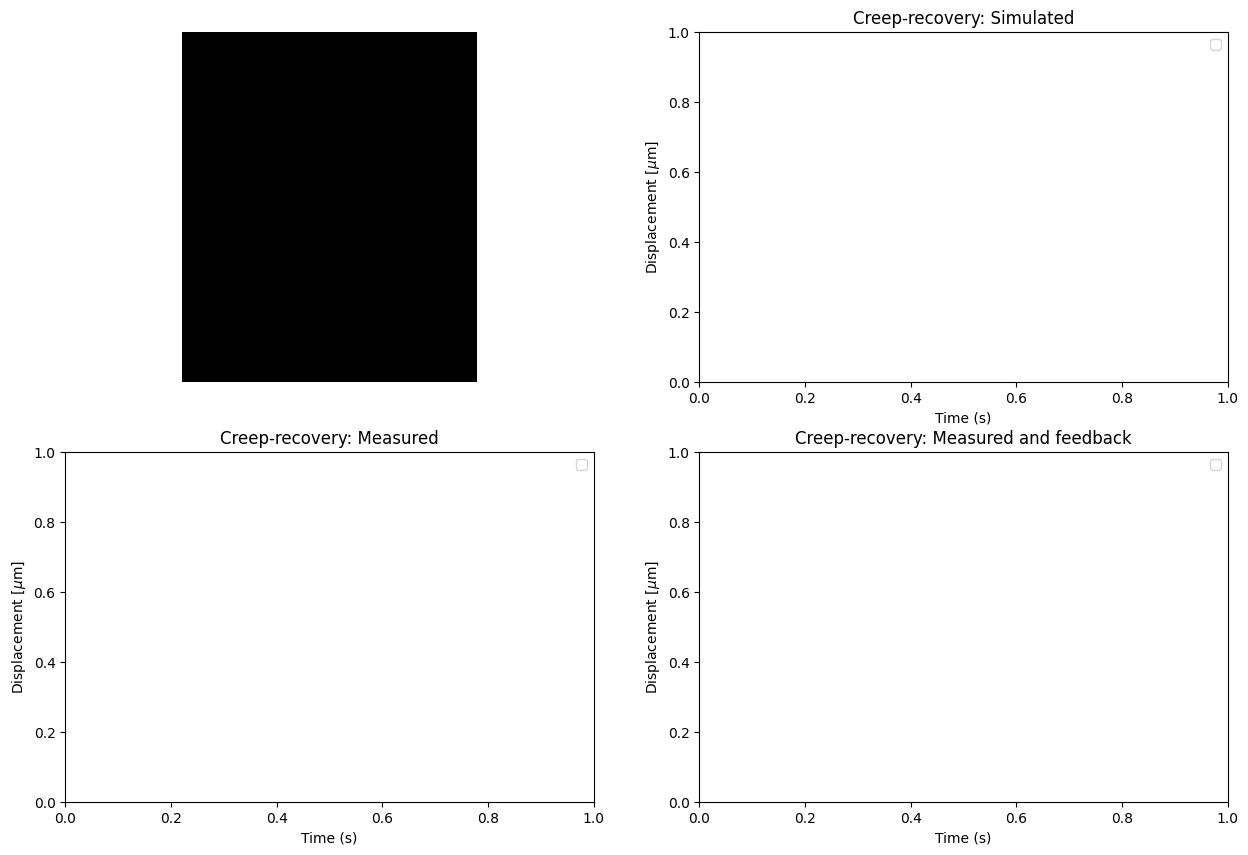

In [90]:
""""
path_driver = "./test/driver.npy"
path_frame = "./test/FrameInfo_4800.npy"

file_driver = np.load(path_driver)
file_frame = np.load(path_frame)


df_current = pd.DataFrame(file_driver.T, columns= ["time", "target", "current", "B", "offset"])

with open(path_track, "rb") as input_file:
    file_track = cPickle.load(input_file)
    
df_track = pd.DataFrame.from_dict(file_track)
df_track["dx"] = scipy.ndimage.gaussian_filter(df_track["x"],5)
df_track["dy"] = scipy.ndimage.gaussian_filter(df_track["y"],5)

df_track["distance"] = df_track["dx"] + df_track["dy"]
df_track["distance"] = df_track["distance"].values.max()- df_track["distance"] 

df_track["time"] = df_track["t"]*1/40



rel = int(100/40)
end_creep = int(df_track["t"].max()*0.75)
start_creep = int(10000/100*5/rel)

plt.plot(df_track["time"], df_track["distance"], label = "data")

t_hat = np.arange(df_track["time"][start_creep:end_creep].min(),df_track["time"][start_creep:end_creep].max(), 0.001)
p, p_ = curve_fit(kelvin, df_track["time"][start_creep:end_creep]-df_track["time"][start_creep:end_creep].values[0], df_track["distance"][start_creep:end_creep], method = "dogbox")
creep_label = "Kelvin-Voigt:\nD: {}\ntau: {}".format(p[1],p[0]) 
plt.plot(t_hat, kelvin(t_hat-t_hat[0],*p), label = creep_label)


plt.vlines(df_track["time"].max()*0.75, 0, df_track["distance"].max(), linestyles ="dashed", colors ="r", label = "end")
plt.vlines(df_track["time"][start_creep], 0, df_track["distance"].max(), linestyles ="dashed", colors ="b", label = "start")

start_rel = end_creep
rel_x = df_track["distance"][start_rel:].values

plt.plot(df_track["time"], df_track["distance"], label = "data")
t_hat_rel = np.arange(df_track["time"][start_rel:].min(),df_track["time"][start_rel:].max(), 0.001)
p, p_ = curve_fit(maxwell_rel, df_track["time"][start_rel:] - df_track["time"][start_rel:].values[0], df_track["distance"][start_rel:], bounds=([rel_x[0]*0.8,0], [rel_x[0]*1.2, 1e3]), maxfev = 10000)
rel_label = "Maxwell relaxation:\nE: {}\ntau: {}".format(p[1],p[0]) 

plt.plot(t_hat_rel, maxwell_rel(t_hat_rel-t_hat_rel[0],*p), label = rel_label)

"""
fig,ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,10))

# example_img = cv2.imread("./data/example_img.png")
# ax[0,0].imshow(example_img)

ax[0,0].imshow(np.zeros((2046,1720,3)))
ax[0,0].axis("off")

ax[0,1].set_title("Creep-recovery: Simulated")
ax[0,1].set_xlabel("Time (s)")
ax[0,1].set_ylabel(r'Displacement [$\mu$m]')
ax[0,1].legend()

ax[1,0].set_title("Creep-recovery: Measured")
ax[1,0].set_xlabel("Time (s)")
ax[1,0].set_ylabel(r'Displacement [$\mu$m]')
ax[1,0].legend()

ax[1,1].set_title("Creep-recovery: Measured and feedback")
ax[1,1].set_xlabel("Time (s)")
ax[1,1].set_ylabel(r'Displacement [$\mu$m]')
ax[1,1].legend()




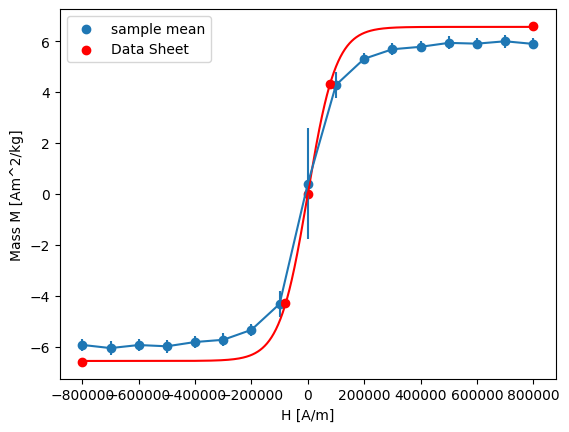

In [181]:
# Units https://www.nist.gov/system/files/documents/pml/electromagnetics/magnetics/magnetic_units.pdf
paths = glob("./data/*.dat")

#These are magnetization values for the beads for micromod data sheet
mgM = np.array([-6.6, -4.3, 0, 4.3, 6.6]) #Mass magnetization
mgH = np.array([-800e3, -80e3, 0, 80e3, 800e3])

for count,i in enumerate(paths):
    end = i.split("\\")[1]
    parts = end.split("_")
    day = parts[0]
    size = float(parts[1][:-7])*1e-6
    weight = float(parts[2][:-6])*1e-6*0.0275

    df_sub = pd.read_csv(i, sep= ",", skiprows = np.arange(0,31)).iloc[1:, :].dropna(how='all', axis = "columns")
    df_sub["sample"] = count
    df_sub["size"] = size
    df_sub["weight"] = weight

    #Oe  1/(4pi)*10^3 A/m
    df_sub["H"] = df_sub["Magnetic Field (Oe)"] * 1/(4*np.pi)*1e3
    #= 1 emu 10−3 A·m2
    df_sub["moment"] = df_sub["Moment (emu)"]*1e-3

    start = np.where(df_sub["H"][:125].values>600e3)[0][0]

    end = np.argmax(df_sub["H"][:125].values)
    k = np.polyfit(df_sub["H"][start:end].values,df_sub["moment"][start:end].values-df_sub["moment"][start:end].values[0],deg = 1, cov = False)
    offset = k[0]*df_sub["H"]
    df_sub["moment"] = df_sub["moment"] - offset
    #print(weight)
    df_sub["M_mass"] = df_sub["moment"]/(weight)
    df_sub["M"] =  df_sub["moment"]/(4/3*np.pi*(size/2)**3)
    #plt.plot(df_sub["H"],df_sub["M_mass"], label = "measured sample {}".format(count))
    if count == 0:
        df =df_sub
    else:
        df = pd.concat((df,df_sub))


df["H_round"] = np.round(df["H"].values, -5)
fd_mean = df.groupby(["H_round"]).mean().reset_index()
error = df.groupby(["H_round"]).std()["M_mass"].values

plt.errorbar(fd_mean["H_round"],fd_mean["M_mass"], yerr = error)
plt.scatter(fd_mean["H_round"],fd_mean["M_mass"], label = "sample mean")

plt.scatter(mgH,mgM, color = "red", label = "Data Sheet")
xdata = np.linspace(-800000,800000,1000)
popt, pcov = curve_fit(func, mgH, mgM, bounds = [[0,1/100000],[8,1/5000]])
plt.plot(xdata, func(xdata, *popt),color = "red")
M = func(xdata, *popt)

plt.xlabel("H [A/m]")
plt.ylabel("Mass M [Am^2/kg]")

plt.legend()



In [71]:
10**-3 - 1e-3

0.0

Micromechanical models fits on displacements

In [ ]:
#path_calib = "./test/calib.npy"
path_driver = "./test/driver.npy"
path_frame = "./test/FrameInfo_4800.npy"
path_track = "./test/trackingData.pickle"

#file_calib = np.load(path_calib)
file_driver = np.load(path_driver)
file_frame = np.load(path_frame)

with open(path_track, "rb") as input_file:
    file_track = cPickle.load(input_file)

df_current = pd.DataFrame(file_driver.T, columns= ["time", "target", "current", "B", "offset"])
df_track = pd.DataFrame.from_dict(file_track)

df_track["dx"] = scipy.ndimage.gaussian_filter(df_track["x"],5)
df_track["dy"] = scipy.ndimage.gaussian_filter(df_track["y"],5)

df_track["distance"] =df_track["dx"] + df_track["dy"]
df_track["distance"] = df_track["distance"].values.max()- df_track["distance"] 

df_track["time"] = df_track["t"]*1/40

rel = int(100/40)
end_creep = int(df_track["t"].max()*0.75)
start_creep = int(10000/100*5/rel)

plt.plot(df_track["time"], df_track["distance"], label = "data")
t_hat = np.arange(df_track["time"][start_creep:end_creep].min(),df_track["time"][start_creep:end_creep].max(), 0.001)

p, p_ = curve_fit(kelvin, df_track["time"][start_creep:end_creep]-df_track["time"][start_creep:end_creep].values[0], df_track["distance"][start_creep:end_creep], method = "dogbox")
plt.plot(t_hat, kelvin(t_hat-t_hat[0],*p), label = "Kelvin-Voigt")

print("Kelvin-Voigt:\n D: ", p[1], "\ntau: ", p[0] )

#p, p_ = curve_fit(maxwell, df_track["time"][start_creep:end_creep], df_track["distance"][start_creep:end_creep], method = "dogbox")
#plt.plot(t_hat, maxwell(t_hat,*p), label = "Maxwell")

#print("Maxwell:\n D: ", p_[1], "\ntau: ", p_[0] )

plt.title("Creep-recovery")
plt.xlabel("Time (s)")
plt.ylabel(r"Displacement ($\mu$m)")

plt.vlines(df_track["time"].max()*0.75, 0, df_track["distance"].max(), linestyles ="dashed", colors ="r", label = "end")
plt.vlines(df_track["time"][start_creep], 0, df_track["distance"].max(), linestyles ="dashed", colors ="b", label = "start")

start_rel = end_creep

rel_x = df_track["distance"][start_rel:].values

plt.plot(df_track["time"], df_track["distance"], label = "data")
t_hat_rel = np.arange(df_track["time"][start_rel:].min(),df_track["time"][start_rel:].max(), 0.001)
#t_hat_rel -= t_hat_rel[0]

p, p_ = curve_fit(maxwell_rel, df_track["time"][start_rel:] - df_track["time"][start_rel:].values[0], df_track["distance"][start_rel:], bounds=([rel_x[0]*0.8,0], [rel_x[0]*1.2, 1e3]), maxfev = 10000)
plt.plot(t_hat_rel, maxwell_rel(t_hat_rel-t_hat_rel[0],*p), label = "Maxwell rel")
print("Maxwell relaxation:\n E: ", p[1], "\ntau: ", p[0] )

plt.legend()
plt.show()

#plt.plot(df_current["offset"])


Multiple particle tracker - Ossi derivation

Kelvin-Voigt:
 D:  0.9614515143057517 
tau:  2.358000522314679
Maxwell relaxation:
 E:  25.50004625894535 
tau:  0.9850670537921418


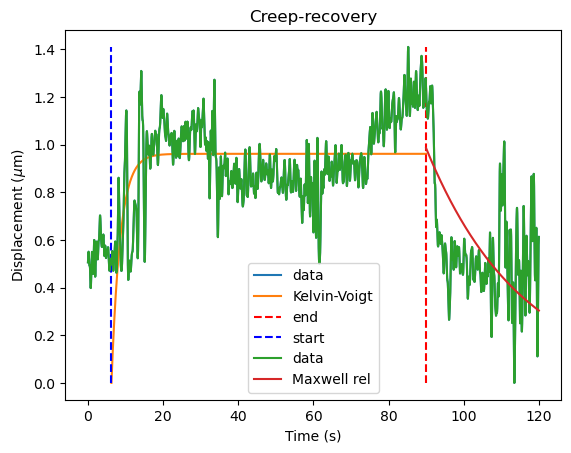

In [22]:
import datetime
print(datetime.datetime.now().date)

<built-in method date of datetime.datetime object at 0x0000014AA1CC5DB0>


Maxwell relaxation:
 D:  [-1.85831945  6.96092928] 
tau:  [ 0.49941154 -1.85831945]


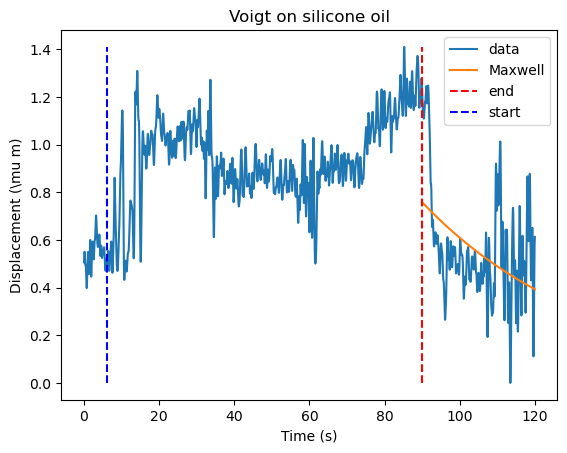

In [172]:
start_rel = end_creep

plt.plot(df_track["time"], df_track["distance"], label = "data")
t_hat_rel = np.arange(df_track["time"][start_rel:].min(),df_track["time"][start_rel:].max(), 0.001)

p, p_ = curve_fit(maxwell_rel, df_track["time"][start_rel:], df_track["distance"][start_rel:], bounds=([0,0], [1e3, 1e3]), maxfev = 10000)
plt.plot(t_hat_rel, maxwell_rel(t_hat_rel,*p), label = "Maxwell")

print("Maxwell relaxation:\n D: ", p_[1], "\ntau: ", p_[0] )

plt.title("Voigt on silicone oil")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (\mu m)")

plt.vlines(df_track["time"].max()*0.75, 0, df_track["distance"].max(), linestyles ="dashed", colors ="r", label = "end")
plt.vlines(df_track["time"][start_creep], 0, df_track["distance"].max(), linestyles ="dashed", colors ="b", label = "start")

plt.legend()
plt.show()

#plt.plot(df_current["offset"])



In [3]:
file =  "./data/One_coil.csv"


df = pd.read_csv(file, sep = ",", skiprows= [0,1], names = ["x", "y", "By", "Bx"])
#drop not needed
df.drop(df[df["y"].values < (3.5-0.9)*1e-3].index, inplace = True)
df.drop(df[df["x"].values > 0.3*1e-3].index, inplace = True)

df["y"] -= max(df["y"].values)
df["y"] = np.abs(df["y"])

df["x"] = np.round(df["x"],5)
df["y"] = np.round(df["y"],5)

df["Bx"] = scipy.ndimage.gaussian_filter1d(df["Bx"].values,5)
df["By"] = scipy.ndimage.gaussian_filter1d(df["By"].values,5)

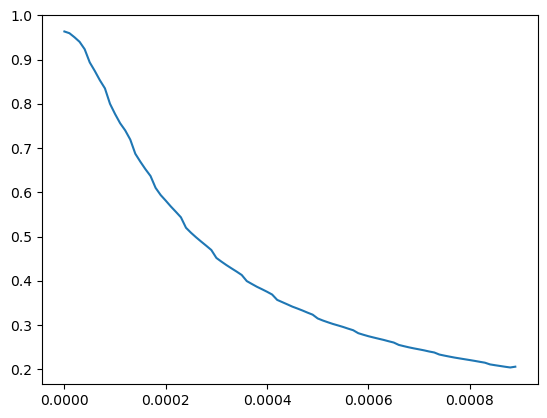

In [4]:
mask = df["x"] == 0
plt.plot(df["y"][mask],df["By"][mask])

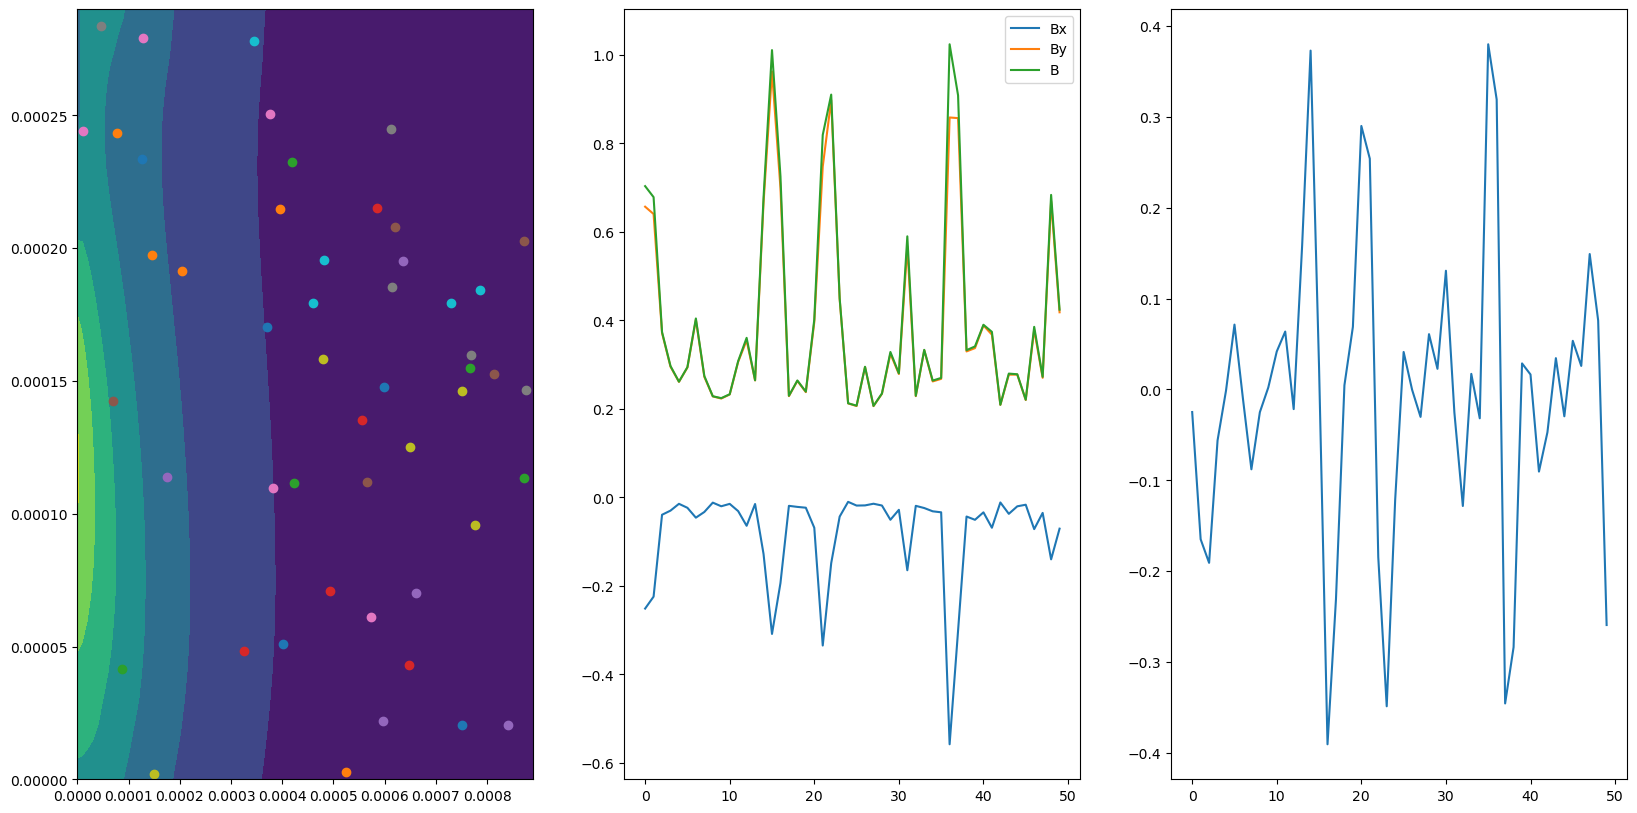

In [5]:
fig, ax = plt.subplots(1,3, figsize = (20,10))

center = 0.5e-5

x = np.random.uniform(low=0, high=max(df["x"].values), size=(50,))
y = np.abs(np.random.uniform(low=0, high=max(df["y"].values), size=(50,)) - center)

x_val = np.zeros(50)
y_val = np.zeros(50)
tot_B = np.zeros(50)

xx, yy = np.meshgrid(df["x"].unique(), df["y"].unique())
data = np.array(df["By"].values).reshape(len(df["y"].unique()),len(df["x"].unique()))
ax[0].contourf(yy,xx, data)

for i in range(len(x)):
    h = ax[0].scatter(y[i],x[i])
    mg_idx = np.where((df["x"].values == np.round(x[i],5)) & (df["y"].values == np.round(y[i],5)))
    x_val[i] =  df["Bx"].values[mg_idx]
    y_val[i] =  df["By"].values[mg_idx]

    tot_B[i] = np.sqrt(x_val[i]**2 + y_val[i]**2)


ax[1].plot(np.arange(50), x_val, label = "Bx")
ax[1].plot(np.arange(50), y_val, label = "By")
ax[1].plot(np.arange(50), tot_B, label = "B")
ax[1].legend()

ax[2].plot(np.gradient(tot_B))


#h.colorbar()


In [6]:
error

NameError: name 'error' is not defined